## Analysis of 3DDPD benchmark PCM dataset and results

In [1]:
import os
import pandas as pd

import papyrus_scripts
from papyrus_scripts.preprocess import keep_quality, keep_accession, keep_protein_class, consume_chunks
from papyrus_scripts.reader import read_papyrus, read_protein_set, read_protein_descriptors

from utils import get_directories
from src.modelling.PCM_papyrus_modelling_analysis import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set paths to modelling data and PCM results
md_dir, md_analysis_dir, desc_dir, desc_dir_dend, pcm_dir, PAPYRUS_DIR = get_directories('./directories.json')
# Define version of Papyrus 
PAPYRUS_VERSION = '05.5'

### Analysis of PCM bioactivity dataset (Papyrus v 05.5)

In [7]:
# Define uniprot name and accession codes for targets of interest (3ddpd set)
targets = {'5ht1b_human': 'P28222', 
           '5ht2b_human': 'P41595',
           'aa1r_human': 'P30542',
           'aa2ar_human': 'P29274',
           'acm1_human': 'P11229',
           'acm2_human': 'P08172',
           'acm4_human': 'P08173',
           'adrb2_human': 'P07550',
           'agtr1_human': 'P30556',
           'ccr5_human': 'P51681',
           'cnr1_human': 'P21554',
           'cxcr4_human': 'P61073',
           'drd3_human': 'P35462',
           'ednrb_human': 'P24530',
           'ffar1_human': 'O14842',
           'hrh1_human': 'P35367',
           'lpar1_human': 'Q92633',
           'oprd_human': 'P41143',
           'oprk_human': 'P41145',
           'oprx_human': 'P41146',
           'ox1r_human': 'O43613',
           'ox2r_human': 'O43614',
           'p2ry1_human': 'P47900',
           'p2y12_human': 'Q9H244',
           'par1_human': 'P25116',
           's1pr1_human': 'P21453'
             }

# Define target IDs for mapping in Papyrus
target_ids = [f'{accession}_WT' for accession in targets.values()]

  0%|          | 0/598 [00:00<?, ?it/s]

Number of bioactivity datapoints
5ht1b_human (P28222) : 524
5ht2b_human (P41595) : 1125
aa1r_human (P30542) : 3519
aa2ar_human (P29274) : 3991
acm1_human (P11229) : 1273
acm2_human (P08172) : 791
acm4_human (P08173) : 584
adrb2_human (P07550) : 1002
agtr1_human (P30556) : 876
ccr5_human (P51681) : 1252
cnr1_human (P21554) : 3741
cxcr4_human (P61073) : 402
drd3_human (P35462) : 3152
ednrb_human (P24530) : 126
ffar1_human (O14842) : 1304
hrh1_human (P35367) : 817
lpar1_human (Q92633) : 156
oprd_human (P41143) : 2219
oprk_human (P41145) : 2910
oprx_human (P41146) : 1155
ox1r_human (O43613) : 1820
ox2r_human (O43614) : 1901
p2ry1_human (P47900) : 370
p2y12_human (Q9H244) : 988
par1_human (P25116) : 665
s1pr1_human (P21453) : 2038


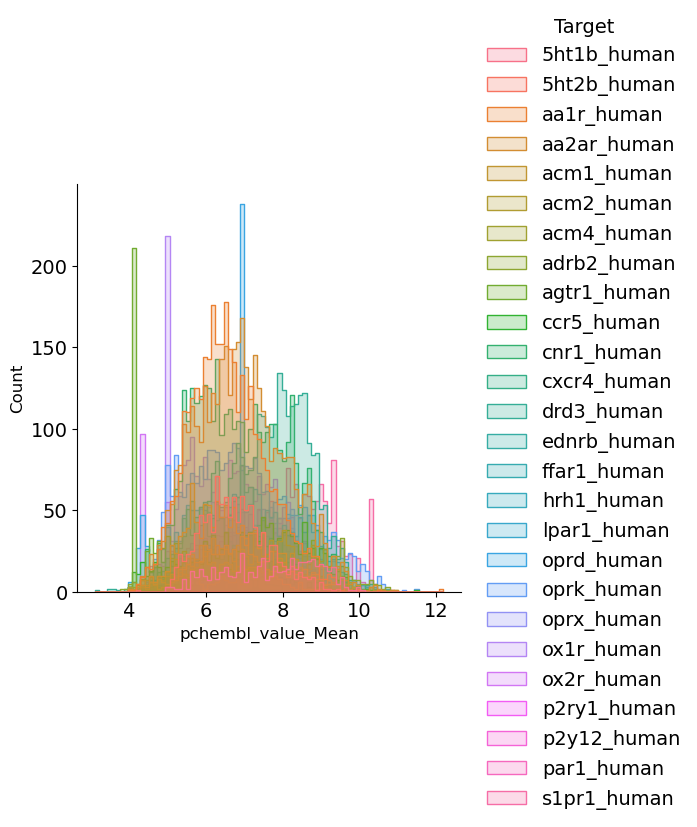

In [13]:
# Get and explore bioactivity dataset
def filter_explore_activity_data(papyrus_version, targets):
    """
    Filter Papyrus dataset for targets of interest and explore the statistics of the resulting dataset

    Parameters
    ----------
    papyrus_version : str
        Version of the Papyrus dataset to read
    targets : dict
        Dictionary with target labels as keys and Uniprot accession codes as values

    Returns
    -------
    pandas.DataFrame
        Filtered bioactivity dataset for input targets
    """
    # Read downloaded Papyrus dataset in chunks, as it does not fit in memory
    CHUNKSIZE = 100000
    data = read_papyrus(version=papyrus_version, chunksize=CHUNKSIZE, source_path=DATA)

    # Create filter for targets of interest
    target_accession_list = targets.values()
    filter = keep_accession(data, target_accession_list)

    # Iterate through chunks and apply the filter defined
    filtered_data = consume_chunks(filter, total=-(-papyrus_scripts.utils.IO.get_num_rows_in_file('bioactivities', False) // CHUNKSIZE))
    # Add column named 'Target' for easier data visualization
    filtered_data['Target'] = filtered_data['accession'].apply(lambda x: [i for i in targets.keys() if targets[i]==x][0])

    # Print number of bioactivity datapoints per target
    print('Number of bioactivity datapoints')
    for target,accession in zip(targets.keys(), targets.values()):
        print(f'{target} ({accession}) : {filtered_data[filtered_data["accession"]==accession].shape[0]}')

    # Plot distribution of activity values (pchembl_value_Mean) per target
    g = sns.displot(filtered_data, x='pchembl_value_Mean', hue='Target', element='step', hue_order=targets.keys())

    return filtered_data

bioactivity_dataset = filter_explore_activity_data(PAPYRUS_VERSION, targets)

In [20]:
# Examine data distribution for the bioactivity dataset 
bioactivity_dataset_stat = bioactivity_dataset.groupby('target_id')['Activity_ID','pchembl_value_Mean'].agg({'Activity_ID': 'count', 'pchembl_value_Mean': ['min','max', 'median','mean','std']})
bioactivity_dataset_stat.reset_index(inplace=True)
bioactivity_dataset_stat.to_csv(os.path.join(pcm_dir,'analysis','bioactivity_dataset_stat.txt'), sep='\t')
bioactivity_dataset_stat

target_id Activity_ID pchembl_value_Mean                                \
                    count                min       max    median      mean   
0   O14842_WT        1304             4.1600   9.52000  6.600000  6.529770   
1   O43613_WT        1820             4.1900   9.80050  6.090000  6.343695   
2   O43614_WT        1901             4.3010  10.05000  6.910000  6.851793   
3   P07550_WT        1002             3.8450  10.92050  7.680000  7.528424   
4   P08172_WT         791             4.0200  10.36400  6.920000  6.983494   
5   P08173_WT         584             4.0000  10.75400  6.410000  6.488699   
6   P11229_WT        1273             4.0300  10.85000  6.500000  6.671297   
7   P21453_WT        2038             4.0300  10.80000  7.822000  7.664835   
8   P21554_WT        3741             4.0000  10.52000  6.824000  6.906866   
9   P24530_WT         126             4.0000   9.39000  6.010000  6.075663   
10  P25116_WT         665             4.0150   9.00000  7.160000  6.947939   
11  P28222_WT         524             4.9900  10.05000  7.800000  7.648711   
12  P29274_WT        3991             4.0000  11.00000  6.821333  6.876665   
13  P30542_WT        3519             4.0000  12.20100  6.480000  6.577852   
14  P30556_WT         876             4.0100  10.00000  5.230000  5.901988   
15  P35367_WT         817             4.0100  10.12800  7.000000  7.023696   
16  P35462_WT        3152             3.1000  10.54000  7.621250  7.489943   
17  P41143_WT        2219             4.0000  10.74250  7.000000  6.892119   
18  P41145_WT        2910             4.0900  11.52300  6.850000  7.016953   
19  P41146_WT        1155             4.3200  10.43000  7.540000  7.507864   
20  P41595_WT        1125             4.1900   9.96000  6.690000  6.751429   
21  P47900_WT         370             4.3500  10.52150  6.900000  6.951331   
22  P51681_WT        1252             4.0400  11.52300  7.281000  7.125764   
23  P61073_WT         402             4.1475   9.21000  7.040250  6.914014   
24  Q92633_WT         156             4.7500   8.96125  6.756000  6.698925   
25  Q9H244_WT         988             4.2400   9.60000  7.165000  7.127742   

              
         std  
0   0.917674  
1   1.106884  
2   1.171192  
3   1.538874  
4   1.304047  
5   1.033921  
6   1.195568  
7   1.461328  
8   1.195288  
9   1.001368  
10  0.966253  
11  1.208970  
12  1.168962  
13  1.009271  
14  1.722440  
15  1.170512  
16  1.170707  
17  1.365549  
18  1.414599  
19  1.077493  
20  0.871113  
21  1.173295  
22  1.409193  
23  0.938568  
24  0.818879  
25  1.038083

In [16]:
# Examine data distribution for temporal split test set (cutoff year = 2013)
bioactivity_dataset_temporal_test = bioactivity_dataset[bioactivity_dataset['Year'] >= 2013]
bioactivity_dataset_stat = bioactivity_dataset.groupby('target_id')['Activity_ID'].count()
bioactivity_dataset_temporal_test_stat = bioactivity_dataset_temporal_test.groupby('target_id')['Activity_ID','pchembl_value_Mean'].agg({'Activity_ID': 'count', 'pchembl_value_Mean': ['min','max', 'median','mean','std']})

temporal_test_stat = bioactivity_dataset_temporal_test_stat.join(bioactivity_dataset_stat)
temporal_test_stat.columns = temporal_test_stat.columns.map('_'.join)
temporal_test_stat.rename({'A_c_t_i_v_i_t_y___I_D':'Activity_ID_count_FullSet'}, inplace=True, axis=1)

temporal_test_stat['test_fraction'] = temporal_test_stat['Activity_ID_count'] / temporal_test_stat['Activity_ID_count_FullSet']
temporal_test_stat.reset_index(inplace=True)
temporal_test_stat.to_csv(os.path.join(pcm_dir,'analysis','temporal_test_split_stat.txt'), sep='\t')
temporal_test_stat

target_id  Activity_ID_count  pchembl_value_Mean_min  \
0   O14842_WT                908                  4.1600   
1   O43613_WT               1461                  4.1900   
2   O43614_WT               1548                  4.9600   
3   P07550_WT                267                  3.8450   
4   P08172_WT                188                  4.0300   
5   P08173_WT                323                  4.1400   
6   P11229_WT                489                  4.2750   
7   P21453_WT               1190                  4.3500   
8   P21554_WT               1003                  4.0000   
9   P24530_WT                 21                  4.7900   
10  P25116_WT                150                  4.0150   
11  P28222_WT                 38                  5.0100   
12  P29274_WT               1134                  4.1900   
13  P30542_WT                993                  4.1200   
14  P30556_WT                219                  4.0100   
15  P35367_WT                235                  4.4700   
16  P35462_WT               1504                  3.1000   
17  P41143_WT                744                  4.0000   
18  P41145_WT                932                  4.3000   
19  P41146_WT                171                  4.4000   
20  P41595_WT                519                  4.1900   
21  P47900_WT                267                  4.5400   
22  P51681_WT                273                  4.0400   
23  P61073_WT                273                  4.1475   
24  Q92633_WT                 74                  4.7500   
25  Q9H244_WT                302                  4.5800   

    pchembl_value_Mean_max  pchembl_value_Mean_median  \
0                  9.52000                    6.59375   
1                  9.40000                    6.27750   
2                 10.00000                    7.01750   
3                 10.55000                    7.08500   
4                  9.85000                    6.23500   
5                  9.46000                    6.36800   
6                  9.80000                    6.29000   
7                 10.40000                    8.19000   
8                 10.52000                    6.49750   
9                  9.39000                    6.07000   
10                 9.00000                    7.29000   
11                 9.50000                    5.96000   
12                11.00000                    6.86000   
13                12.20100                    6.62000   
14                10.00000                    7.62000   
15                 9.70000                    6.50000   
16                10.54000                    7.83525   
17                10.38500                    7.00000   
18                10.72000                    7.10000   
19                10.19000                    7.54000   
20                 9.96000                    6.62000   
21                10.52150                    7.23000   
22                 9.40000                    6.90000   
23                 8.82000                    6.91000   
24                 8.96125                    6.89000   
25                 9.10000                    6.89000   

    pchembl_value_Mean_mean  pchembl_value_Mean_std  \
0                  6.509874                0.928011   
1                  6.445495                1.108519   
2                  7.029972                0.982992   
3                  7.024886                1.681130   
4                  6.392860                1.199807   
5                  6.432522                0.841894   
6                  6.352673                0.986778   
7                  7.973301                1.411585   
8                  6.665609                1.158539   
9                  6.341429                1.096450   
10                 6.957170                1.130995   
11                 6.123430                0.873334   
12                 6.848755                1.256762   
13                 6.663070                1.158616   
14                

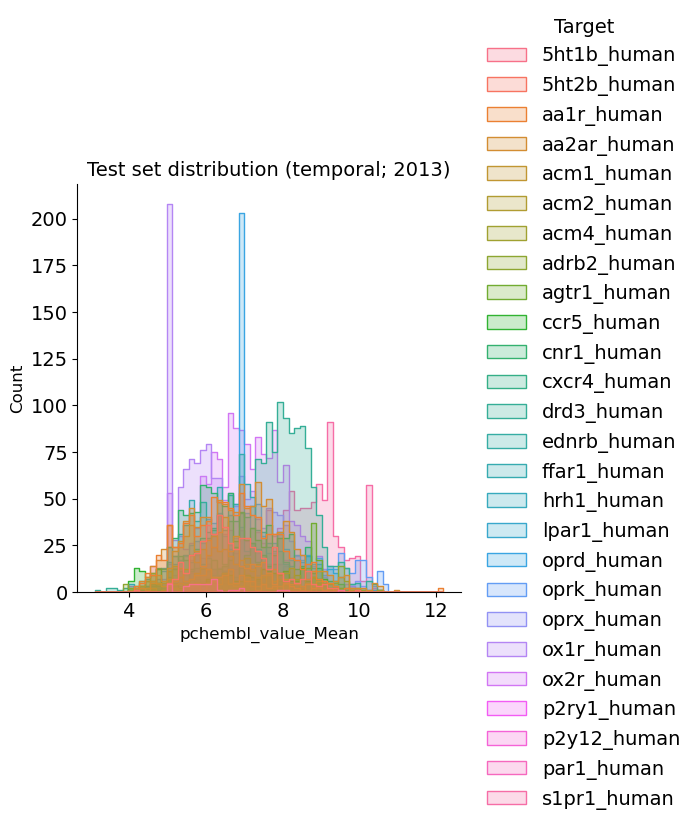

In [26]:
g = sns.displot(bioactivity_dataset_temporal_test, x='pchembl_value_Mean', hue='Target', element='step', hue_order=targets.keys(), )
g.set(title='Test set distribution (temporal; 2013)')    

### Analysis of PCM results

In [3]:
# Define the set of descriptors used for PCM
protein_descriptors_benchmark = ['Zscale_Hellberg', 'Zscale_van_Westen', 'STscale', 'MS-WHIM', 'PhysChem', 'unirep']
protein_descriptors_rs3ddpd = ['3DDPD_RS_all_f100_pc5_fs_aa', '3DDPD_RS_std_f100_pc5_fs_aa', '3DDPD_RS_std_f10_pc5_fs_aa', '3DDPD_RS_std_f50_pc5_fs_aa', 
                               '3DDPD_RS_std_f500_pc5_fs_aa', '3DDPD_RS_std_f100_pc3_fs_aa', '3DDPD_RS_std_f100_pc7_fs_aa', '3DDPD_RS_std_f100_pc10_fs_aa',
                               '3DDPD_RS_std_f100_pc5_fs_rc', '3DDPD_RS_std_f100_pc5_g_aa']
protein_descriptors_ps3ddpd_old = ['3DDPD_PS_all_f100_pc95_fs_aa', '3DDPD_PS_std_f100_pc95_fs_aa', '3DDPD_PS_std_f100_pc99_fs_aa', '3DDPD_PS_std_f100_pc99_fs_rc', 
                               '3DDPD_PS_std_f100_pc99_g_rc','3DDPD_PS_std_f100_pc99_f_rc', '3DDPD_PS_std_f100_pc99_sf_rc', '3DDPD_PS_std_f100_pc99_i_rc']
protein_descriptors_ps3ddpd = ['3DDPD_PS_all_f100_pc95_fs_aa', '3DDPD_PS_std_f100_pc95_fs_aa', '3DDPD_PS_all_f100_pc99_fs_aa','3DDPD_PS_all_f100_pc95_fs_rc',
                               '3DDPD_PS_all_f100_pc95_g_aa','3DDPD_PS_all_f100_pc95_f_aa','3DDPD_PS_all_f100_pc95_sf_aa','3DDPD_PS_all_f100_pc95_i_aa']
protein_descriptors_synergy = ['3DDPD_RS_std_f100_pc5_fs_aa','3DDPD_PS_all_f100_pc95_fs_aa',
                                'Zscale_Hellberg', '3DDPD_RS_std_f100_pc5_fs_aa_Zscale_Hellberg', '3DDPD_PS_all_f100_pc95_fs_aa_Zscale_Hellberg',
                                'Zscale_van_Westen', '3DDPD_RS_std_f100_pc5_fs_aa_Zscale_van_Westen','3DDPD_PS_all_f100_pc95_fs_aa_Zscale_van_Westen',
                                'STscale', '3DDPD_RS_std_f100_pc5_fs_aa_STscale', '3DDPD_PS_all_f100_pc95_fs_aa_STscale',
                                'MS-WHIM', '3DDPD_RS_std_f100_pc5_fs_aa_MS-WHIM', '3DDPD_PS_all_f100_pc95_fs_aa_MS-WHIM',
                                'PhysChem', '3DDPD_RS_std_f100_pc5_fs_aa_PhysChem', '3DDPD_PS_all_f100_pc95_fs_aa_PhysChem']
protein_descriptors = ['QSAR'] + protein_descriptors_benchmark + protein_descriptors_rs3ddpd + protein_descriptors_ps3ddpd
protein_descriptors_all = protein_descriptors + protein_descriptors_synergy
protein_descriptors_MS = ['QSAR'] + protein_descriptors_benchmark + ['3DDPD_RS_std_f100_pc10_fs_aa'] + ['3DDPD_PS_all_f100_pc95_fs_aa']

In [4]:
def get_results_to_plot(protein_descriptor_set):
    # Read and tabulate the results
    results = tabulate_results(os.path.join(pcm_dir, 'models'), protein_descriptor_set)
    # List data of all seeds for plotting
    QSAR, PCM, aggregated = list_all_seeds(results)
    # Return QSAR + PCM aggregated seed results for plotting
    return aggregated

In [5]:
pcm_dir = 'D:\Gorostiola Gonzalez, Marina\PROJECTS\\3_GPCRS_3DDPDs\DATA\\2_Analysis\manuscript\\2_PCM_modelling'

In [16]:
# Get summary of results 
results = tabulate_results(os.path.join(pcm_dir, 'models'), protein_descriptors_all)
# Calculate the average and SD metric accross seeds for the same protein descriptor and split type
seed_average_QSAR,seed_average_PCM = average_over_seeds(results)
seed_average_PCM

model   split            protein_descriptor variable      mean       std
0     PCM  random   3DDPD_PS_all_f100_pc95_f_aa      MCC  0.646234  0.006038
1     PCM  random   3DDPD_PS_all_f100_pc95_f_aa     RMSE  0.703413  0.007653
2     PCM  random   3DDPD_PS_all_f100_pc95_f_aa        r  0.836119  0.003607
3     PCM  random  3DDPD_PS_all_f100_pc95_fs_aa      MCC  0.644716  0.006570
4     PCM  random  3DDPD_PS_all_f100_pc95_fs_aa     RMSE  0.704416  0.006022
..    ...     ...                           ...      ...       ...       ...
169   PCM    year             Zscale_van_Westen     RMSE  1.221101  0.005926
170   PCM    year             Zscale_van_Westen        r  0.409944  0.005814
171   PCM    year                        unirep      MCC  0.273962  0.008430
172   PCM    year                        unirep     RMSE  1.219178  0.004602
173   PCM    year                        unirep        r  0.411132  0.003577

[174 rows x 6 columns]

In [17]:
seed_average_QSAR

model   split protein_descriptor variable      mean       std
0  QSAR  random               QSAR      MCC  0.577714  0.007181
1  QSAR  random               QSAR     RMSE  0.705380  0.005661
2  QSAR  random               QSAR        r  0.774895  0.004677
3  QSAR    year               QSAR      MCC  0.191889  0.009093
4  QSAR    year               QSAR     RMSE  1.168438  0.003839
5  QSAR    year               QSAR        r  0.343006  0.004332

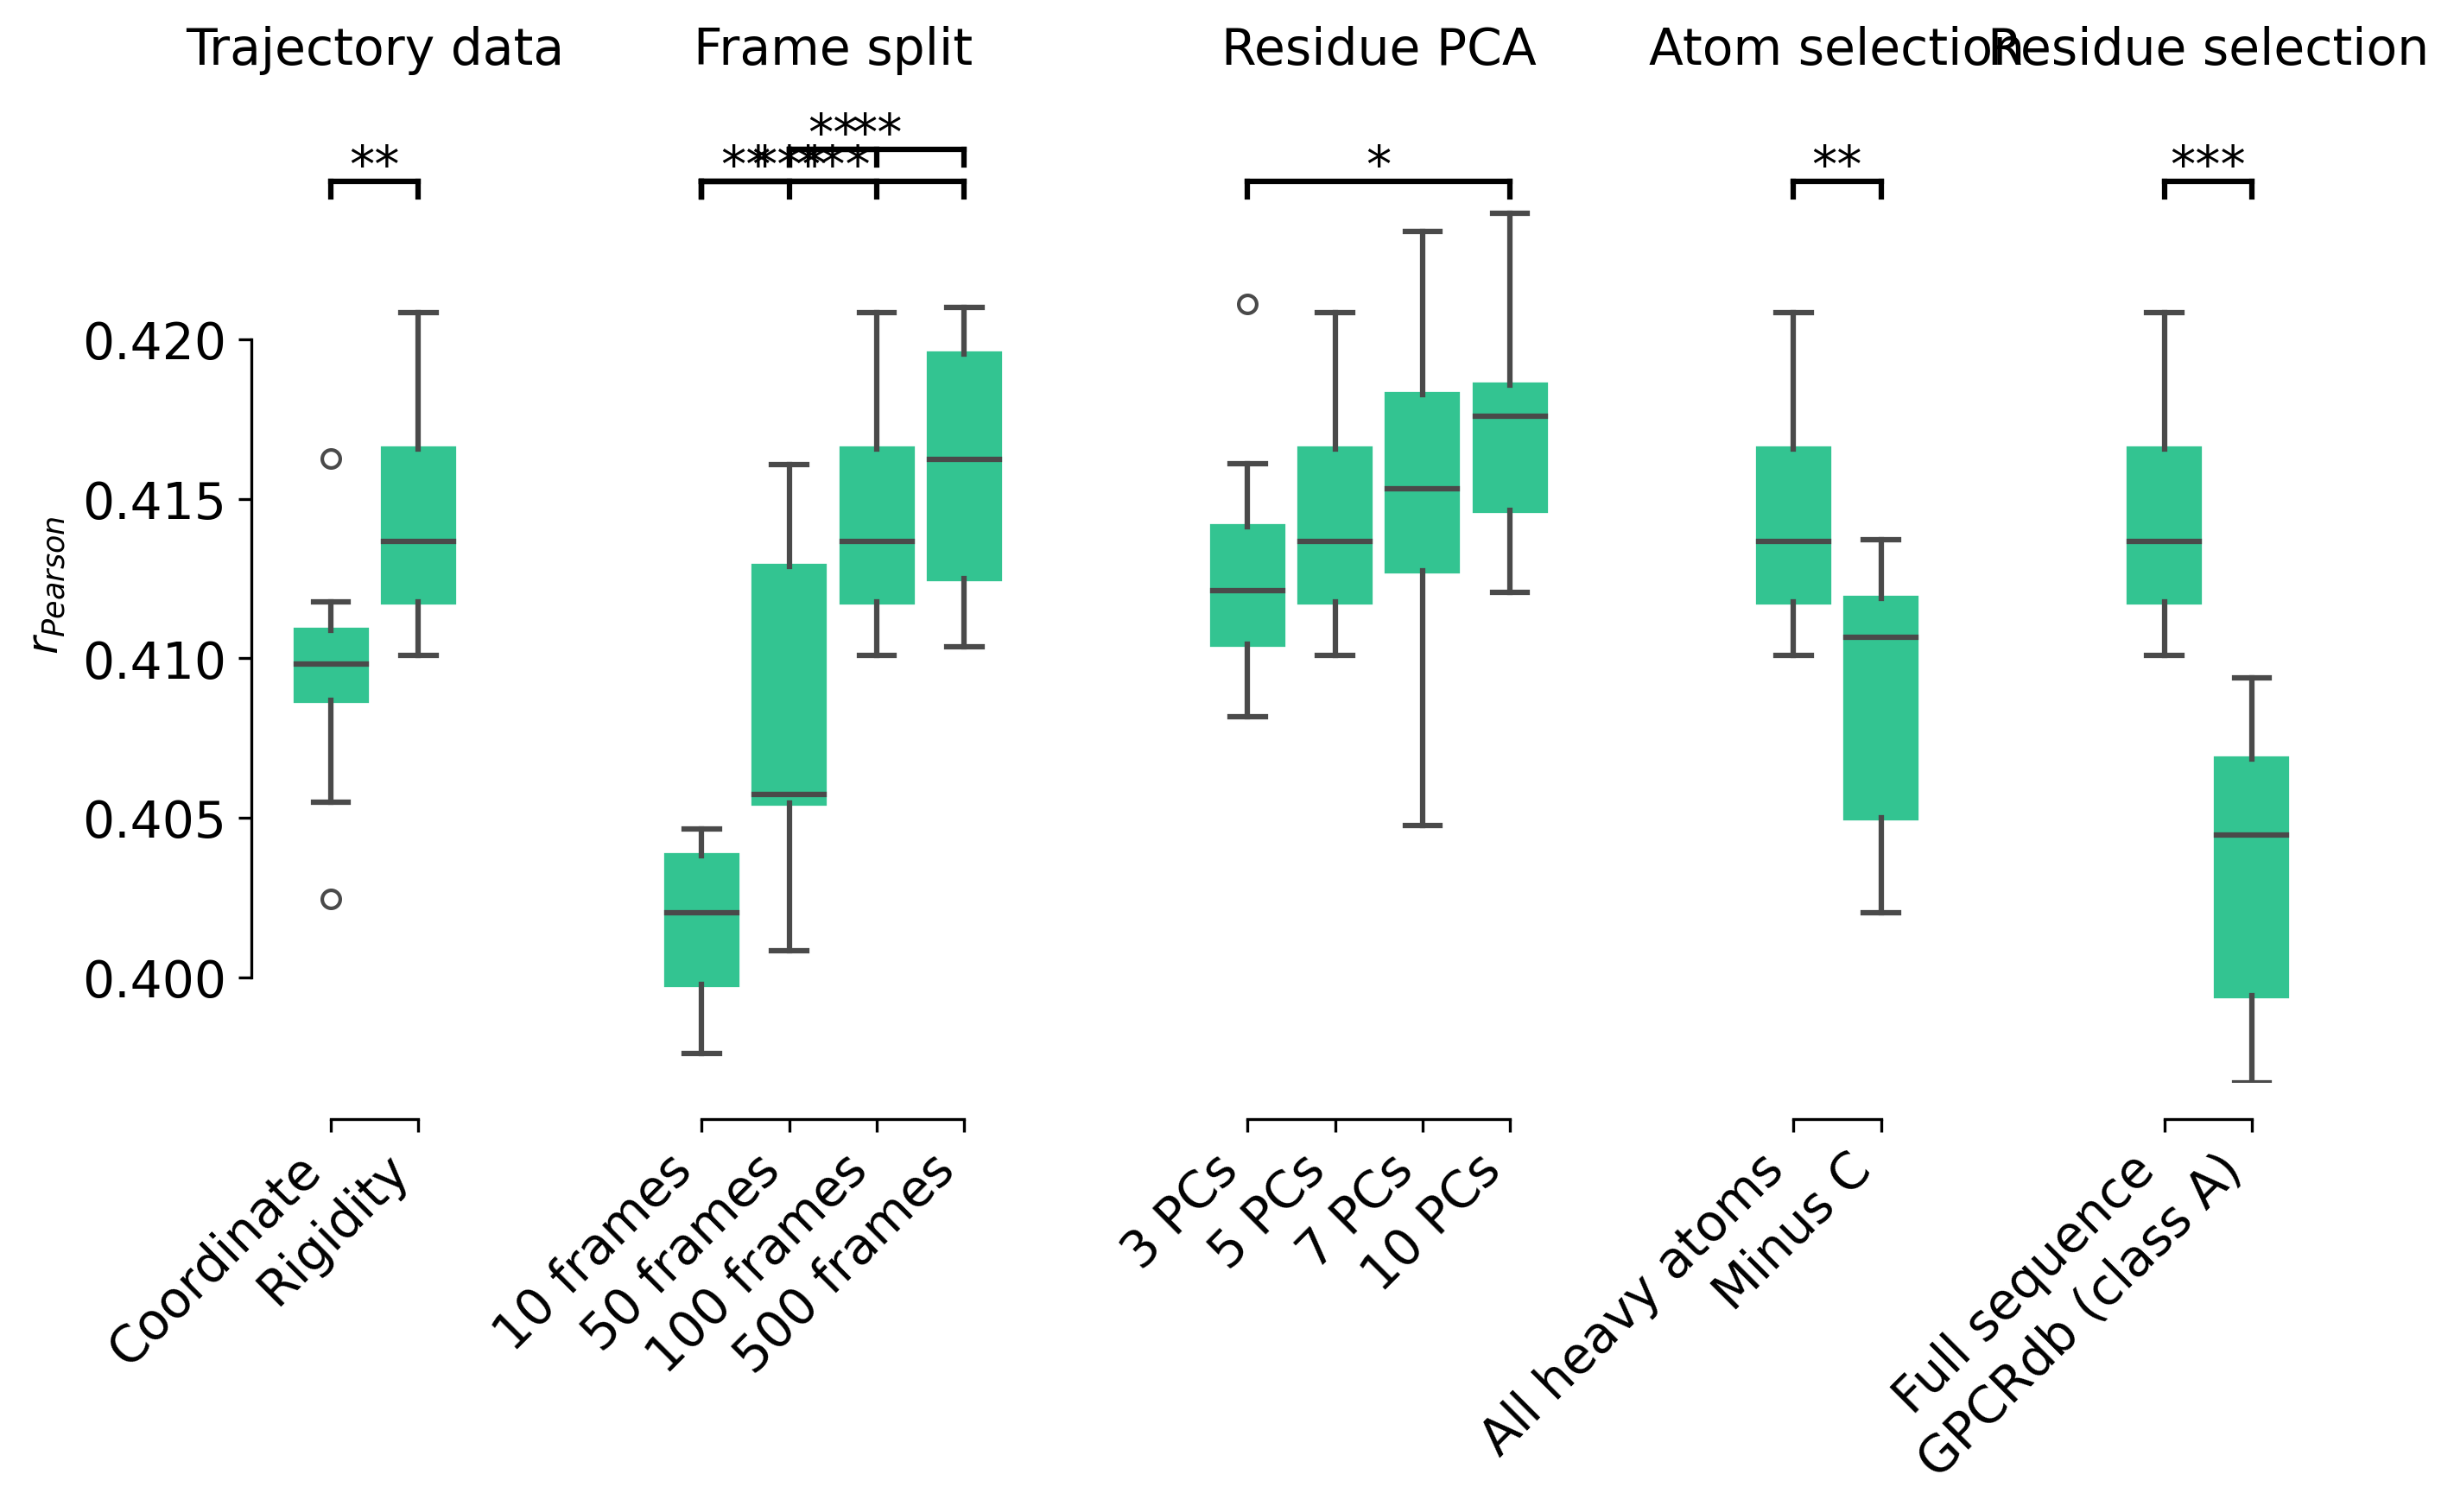

In [19]:
# Plot performance for an individual metric OPTIMIZATION - (boxplots)
RS_optimization_strategy = {'Trajectory data': [('3DDPD_RS_all_f100_pc5_fs_aa', 'Coordinate'),('3DDPD_RS_std_f100_pc5_fs_aa', 'Rigidity')],
                            'Frame split': [('3DDPD_RS_std_f10_pc5_fs_aa','10 frames'),('3DDPD_RS_std_f50_pc5_fs_aa', '50 frames'),('3DDPD_RS_std_f100_pc5_fs_aa', '100 frames'),('3DDPD_RS_std_f500_pc5_fs_aa','500 frames')],
                            'Residue PCA': [ ('3DDPD_RS_std_f100_pc3_fs_aa', '3 PCs'),('3DDPD_RS_std_f100_pc5_fs_aa', '5 PCs'),('3DDPD_RS_std_f100_pc7_fs_aa', '7 PCs'),('3DDPD_RS_std_f100_pc10_fs_aa', '10 PCs')],
                            'Atom selection': [('3DDPD_RS_std_f100_pc5_fs_aa', 'All heavy atoms'),('3DDPD_RS_std_f100_pc5_fs_rc', 'Minus C')],
                            'Residue selection': [('3DDPD_RS_std_f100_pc5_fs_aa', 'Full sequence'),('3DDPD_RS_std_f100_pc5_g_aa','GPCRdb (class A)')]}
plot_optimization_performance(get_results_to_plot(protein_descriptors_rs3ddpd), split='year', desc_filter=protein_descriptors_rs3ddpd, optimization_strategy=RS_optimization_strategy, desc_set='RS_optimization', variable = 'r', plot_significance=True, save=False, output_format = 'svg', output_dir=os.path.join(pcm_dir,'analysis'))

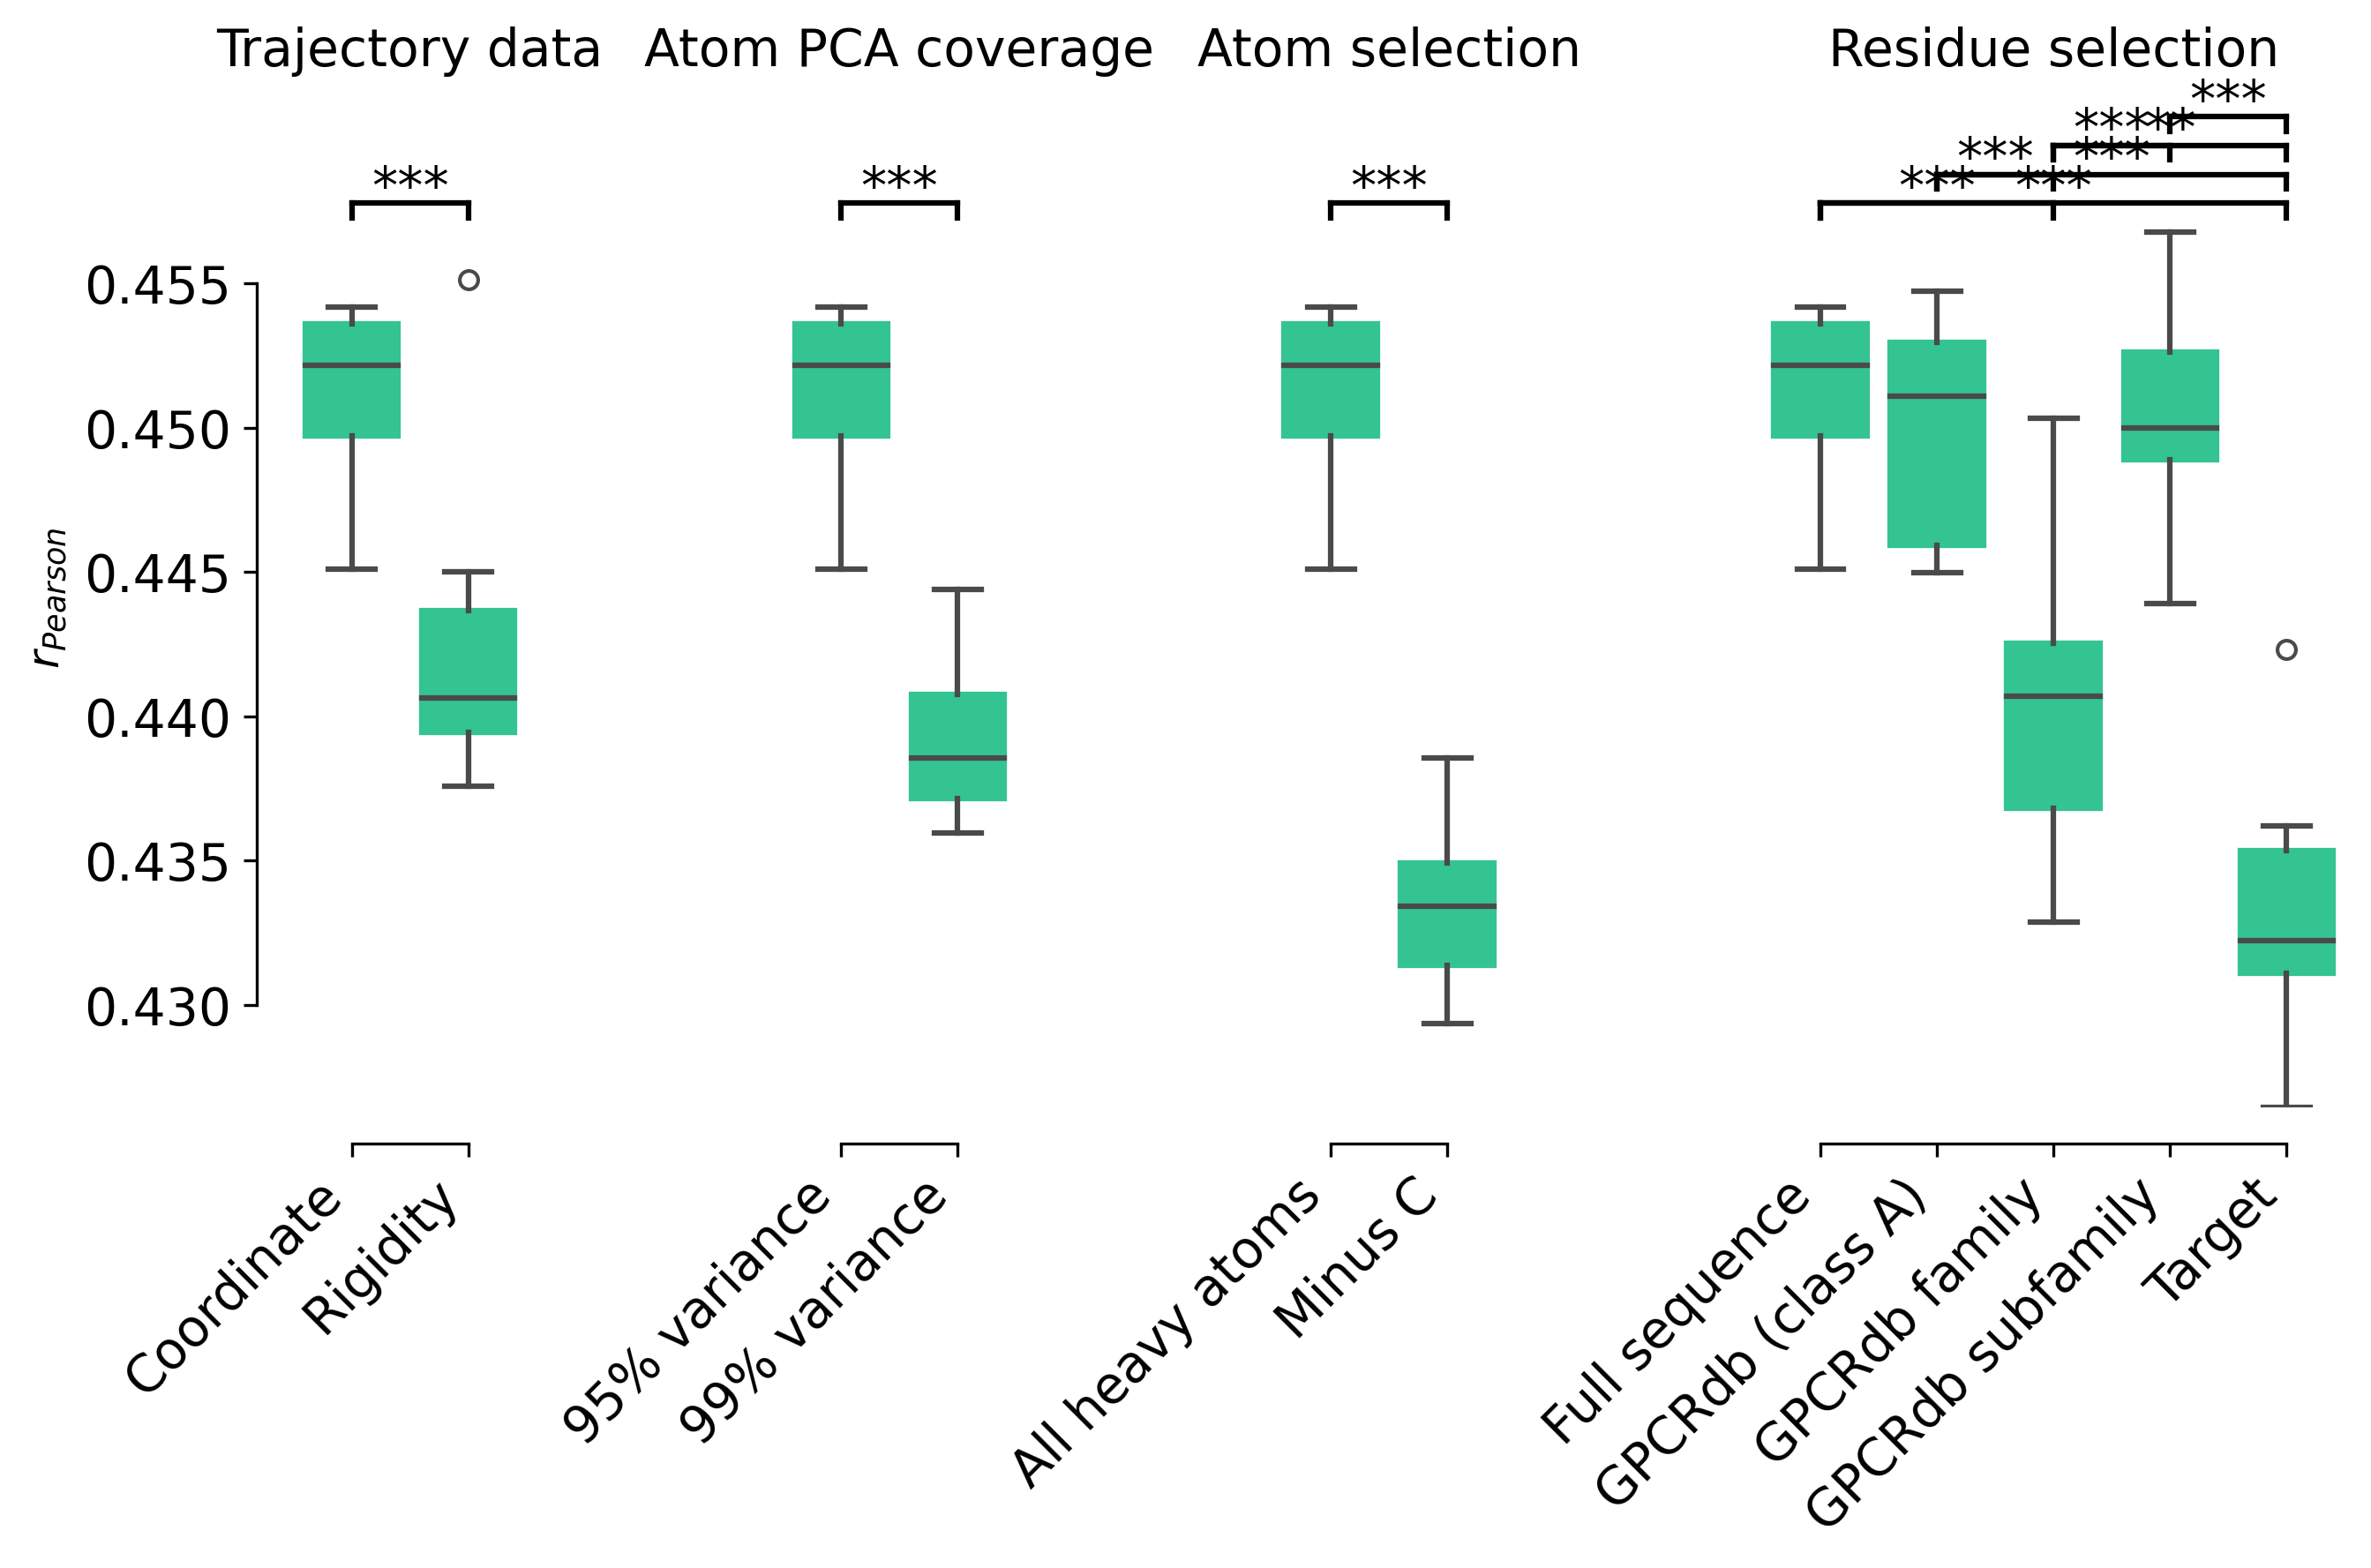

In [20]:
PS_optimization_strategy = {'Trajectory data': [('3DDPD_PS_all_f100_pc95_fs_aa', 'Coordinate'),('3DDPD_PS_std_f100_pc95_fs_aa', 'Rigidity')],
                            'Atom PCA coverage': [('3DDPD_PS_all_f100_pc95_fs_aa', '95% variance'),('3DDPD_PS_all_f100_pc99_fs_aa', '99% variance')],
                            'Atom selection': [('3DDPD_PS_all_f100_pc95_fs_aa', 'All heavy atoms'),('3DDPD_PS_all_f100_pc95_fs_rc', 'Minus C')],
                            'Residue selection': [('3DDPD_PS_all_f100_pc95_fs_aa', 'Full sequence'),('3DDPD_PS_all_f100_pc95_g_aa', 'GPCRdb (class A)'),('3DDPD_PS_all_f100_pc95_f_aa','GPCRdb family'),('3DDPD_PS_all_f100_pc95_sf_aa', 'GPCRdb subfamily'),('3DDPD_PS_all_f100_pc95_i_aa', 'Target')]}


plot_optimization_performance(get_results_to_plot(protein_descriptors_ps3ddpd), split='year', desc_filter=protein_descriptors_ps3ddpd, optimization_strategy=PS_optimization_strategy, desc_set='PS_optimization', variable = 'r', plot_significance=True, save=False,  output_format = 'svg',output_dir=os.path.join(pcm_dir,'analysis'))

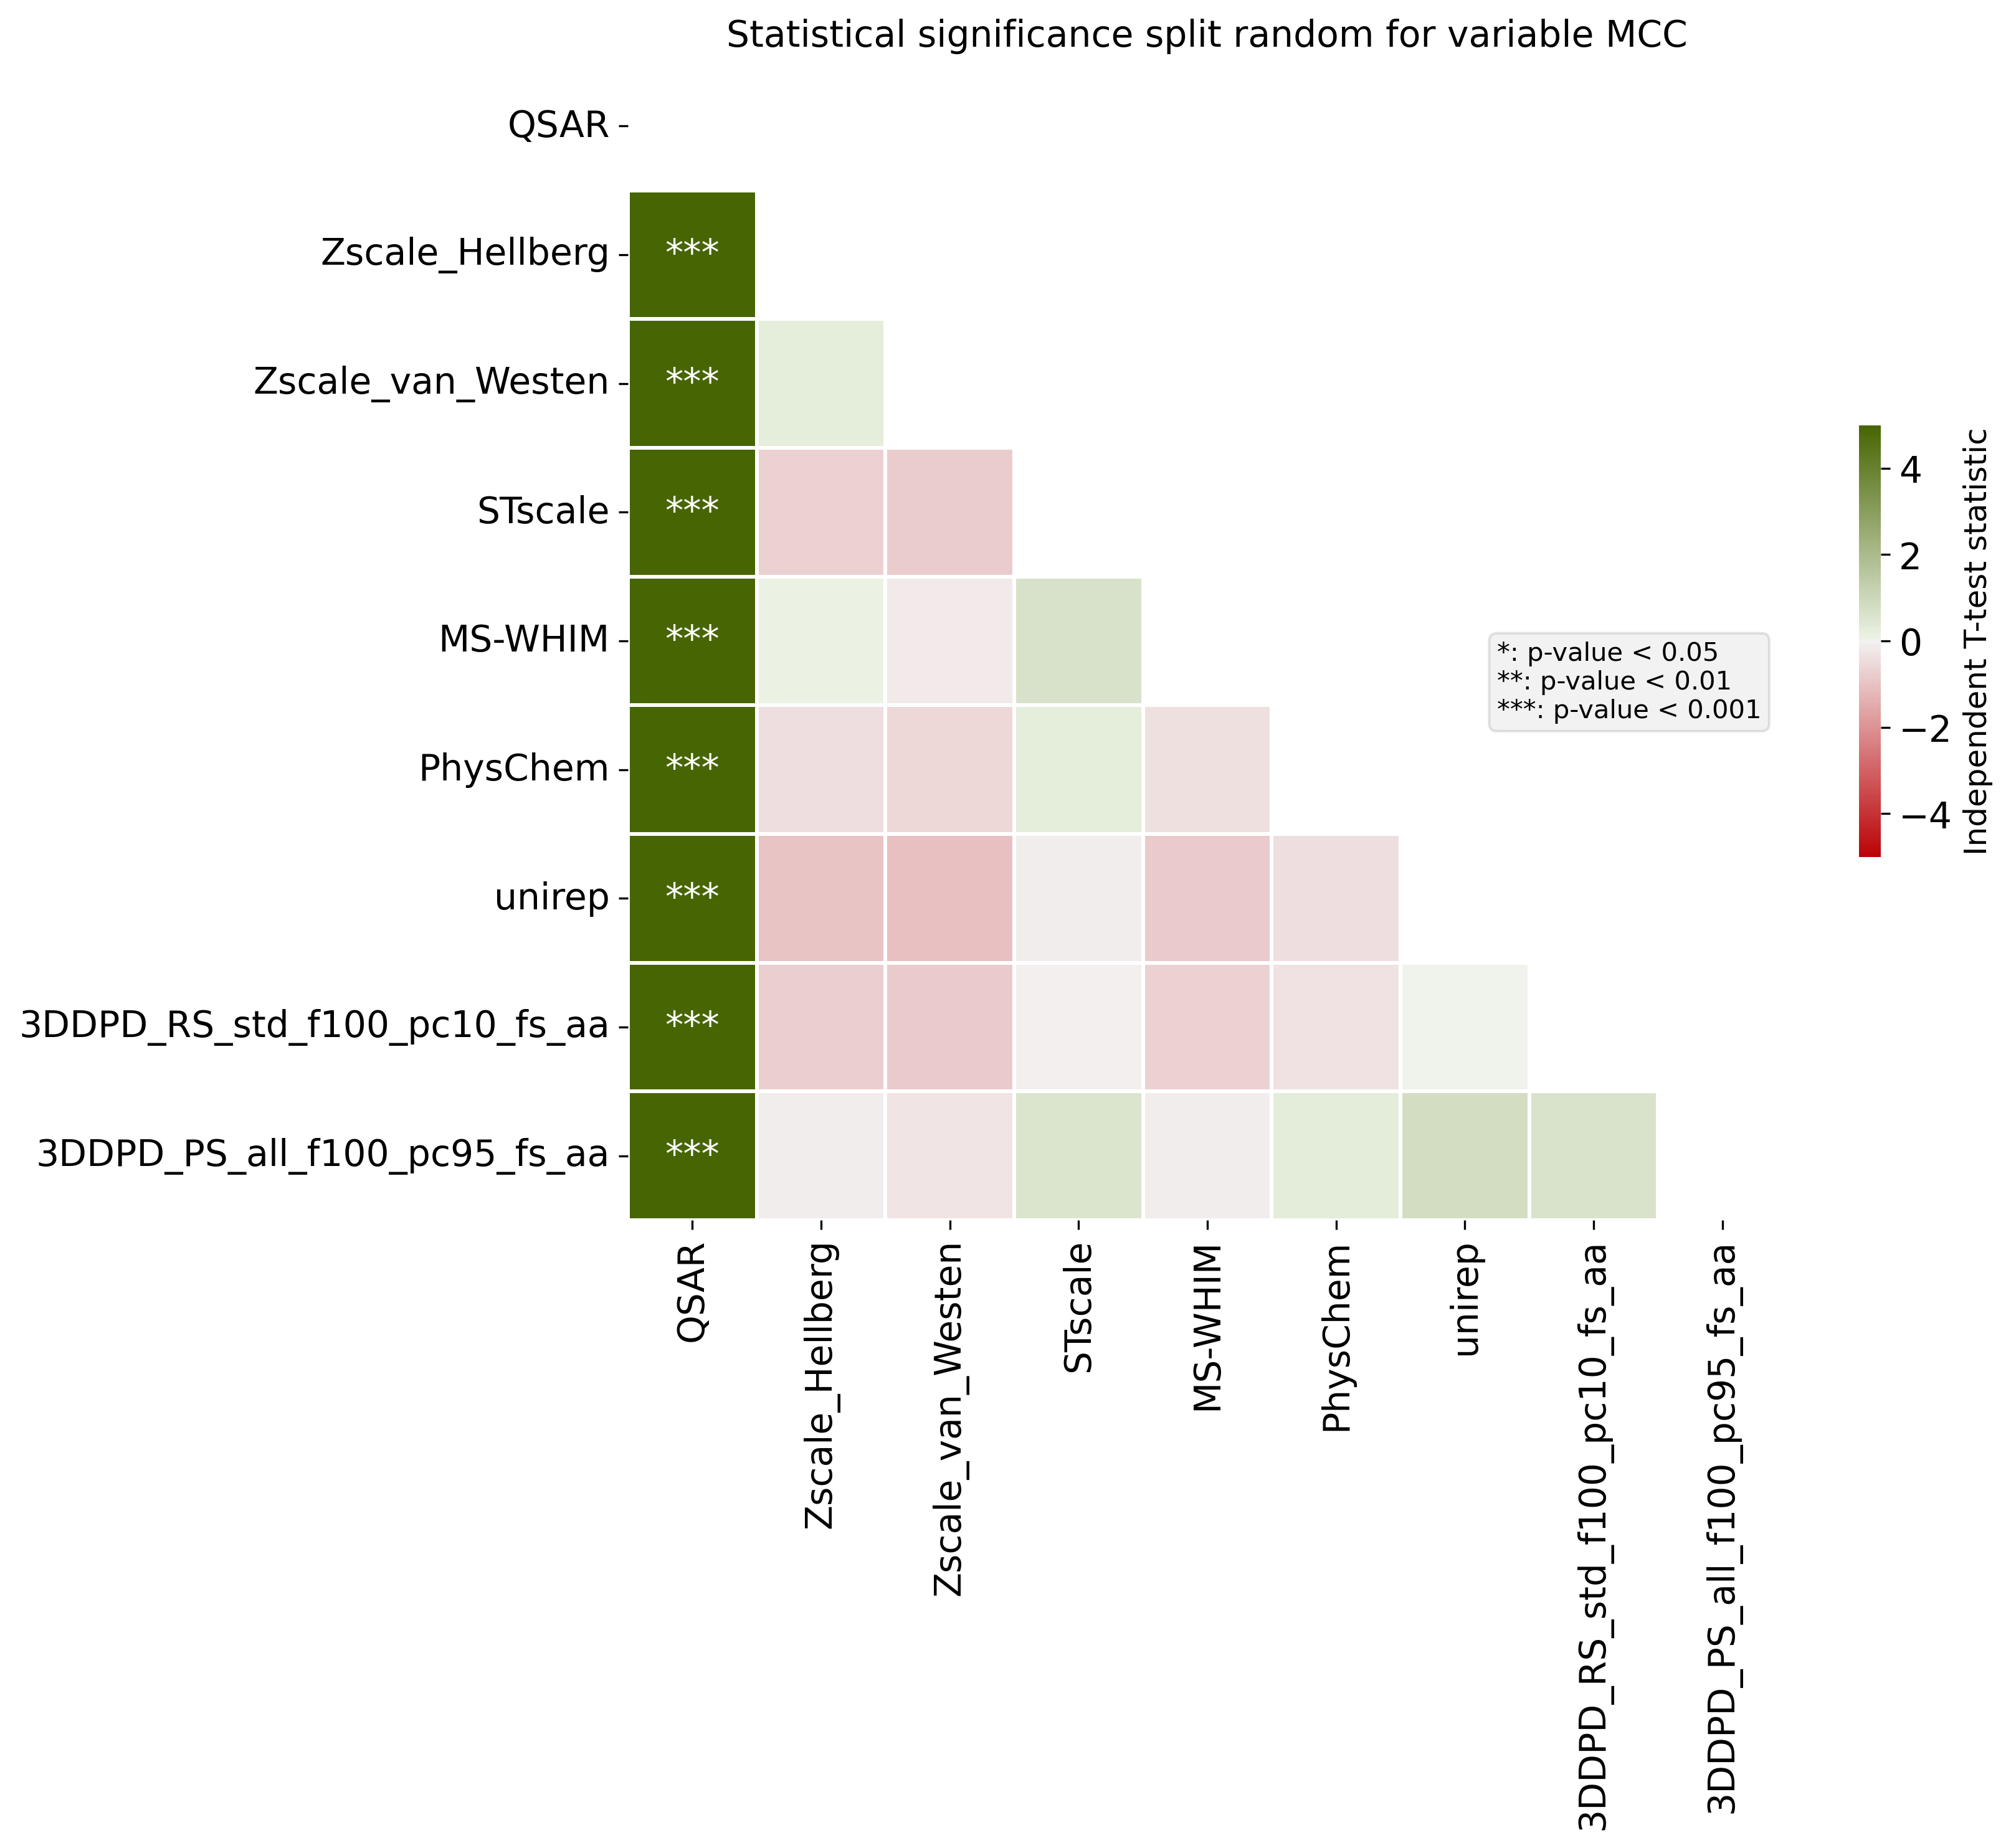

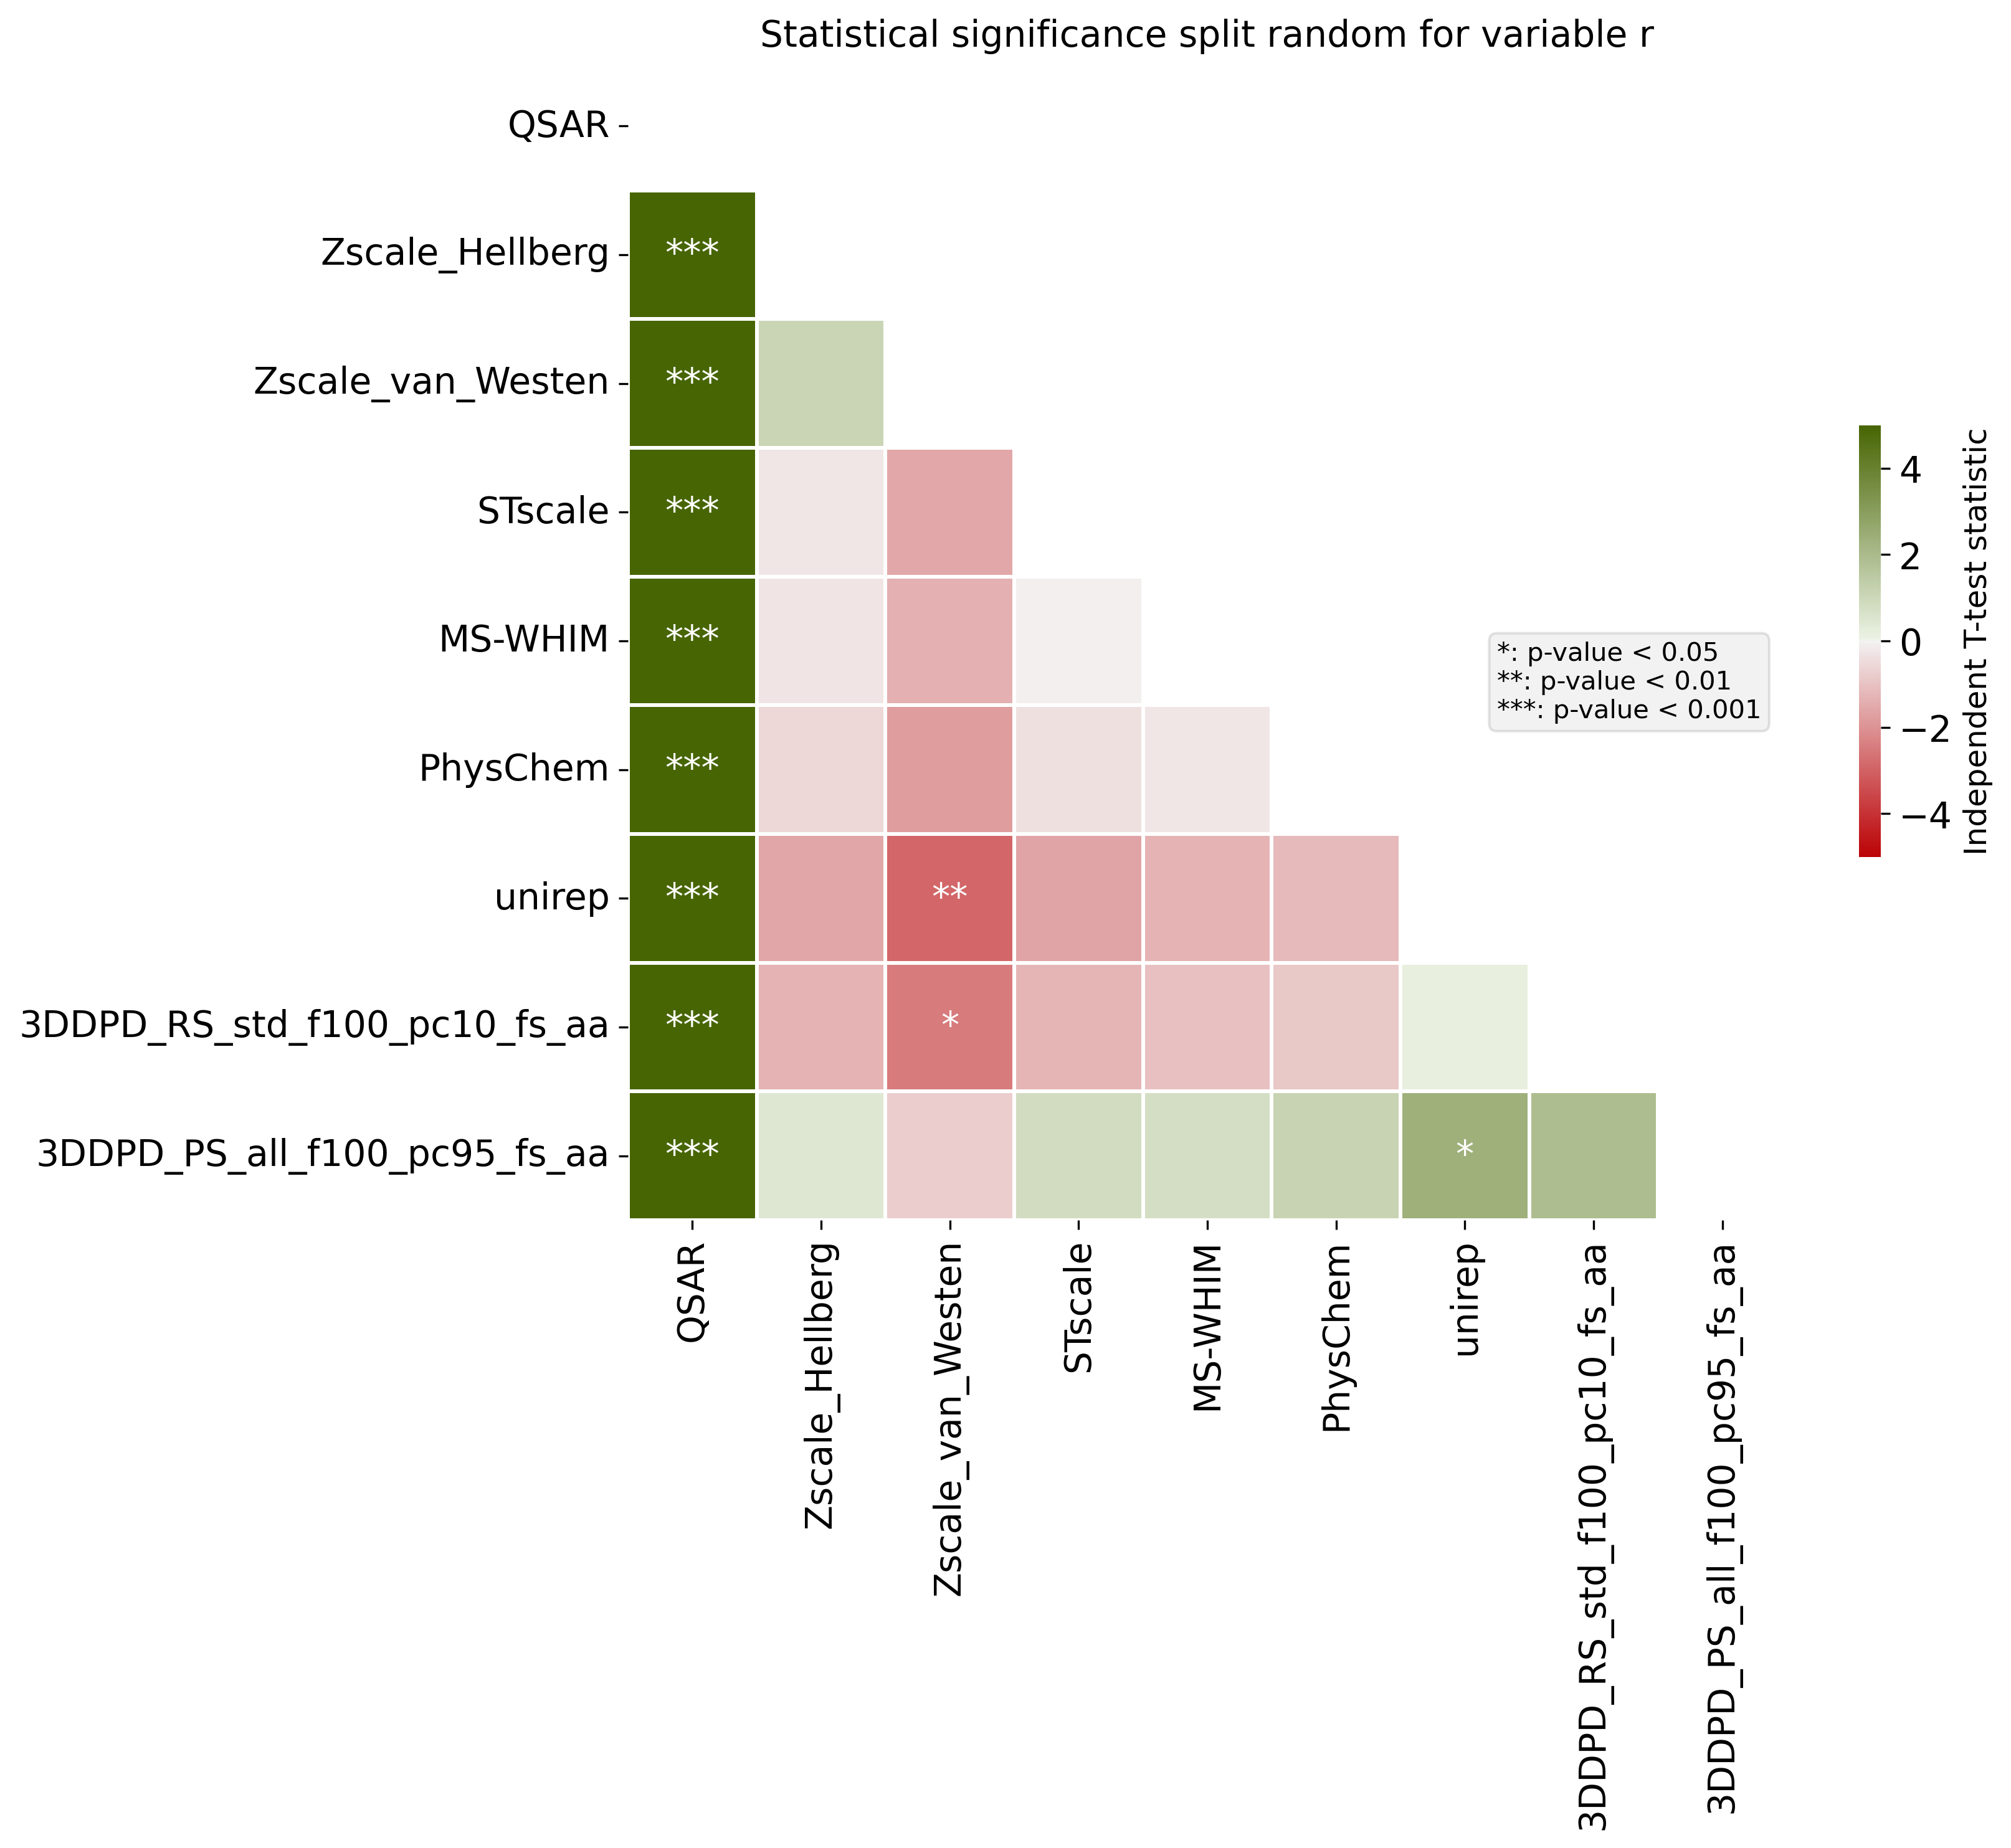

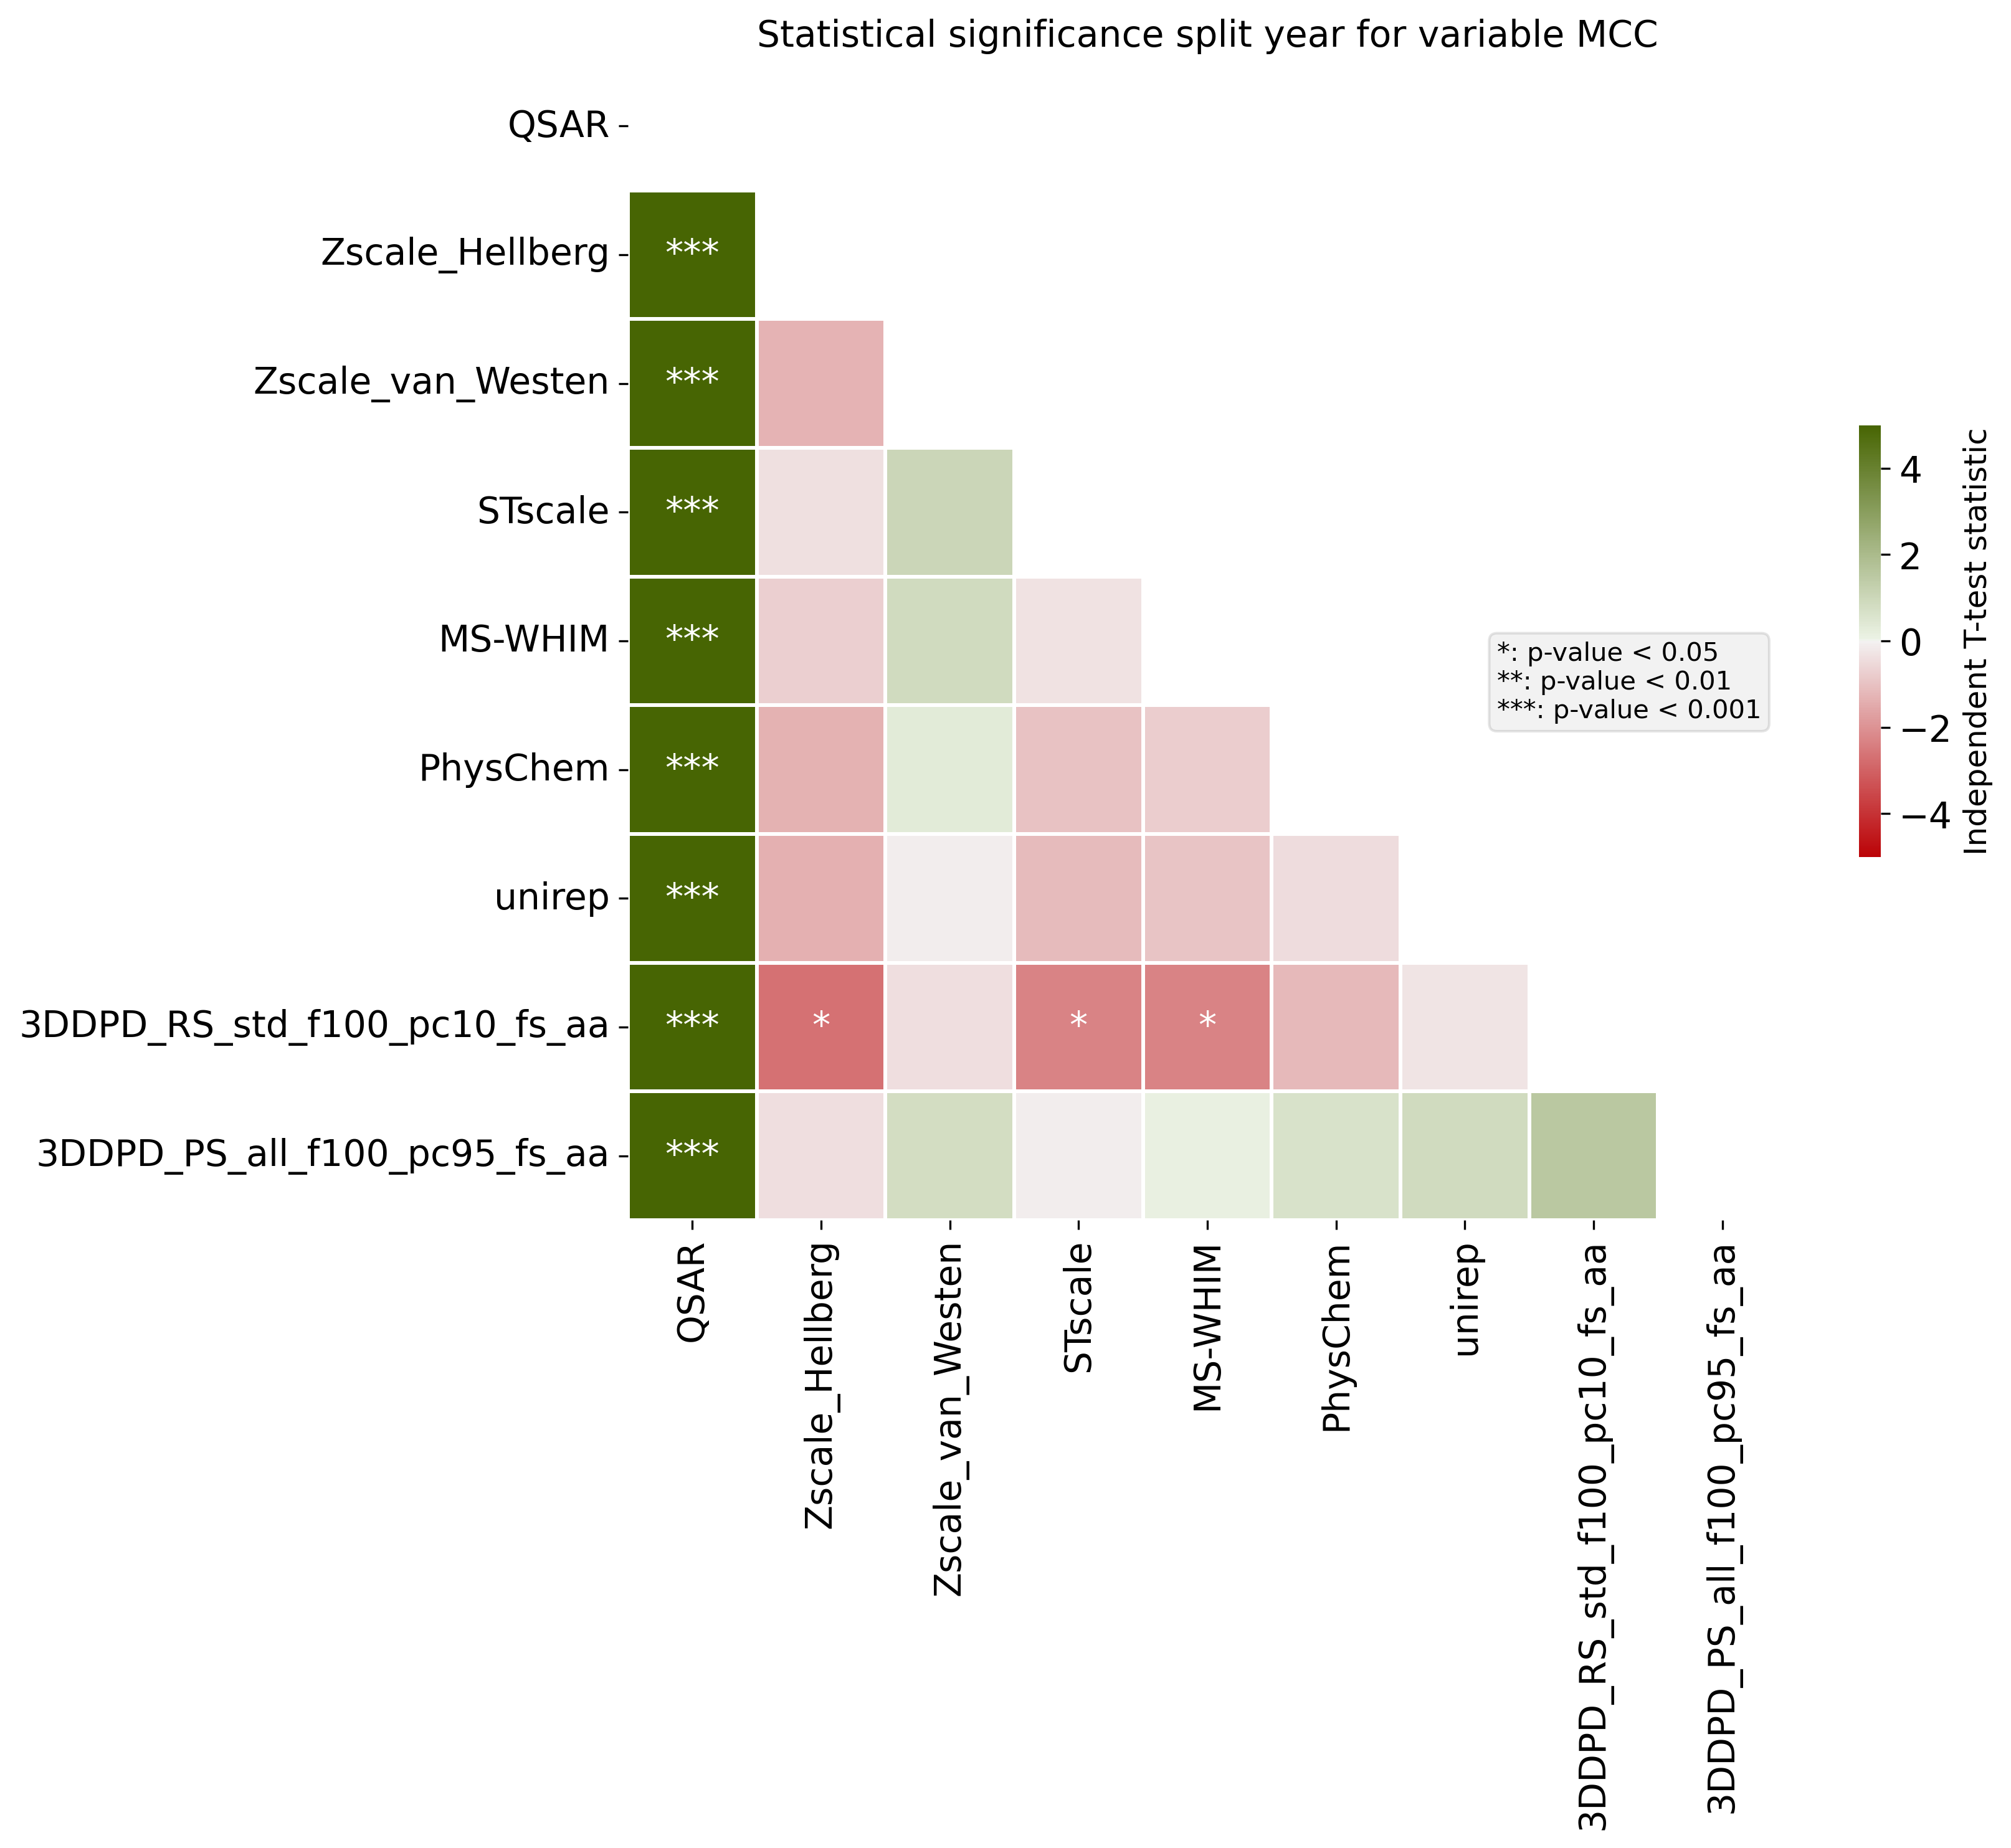

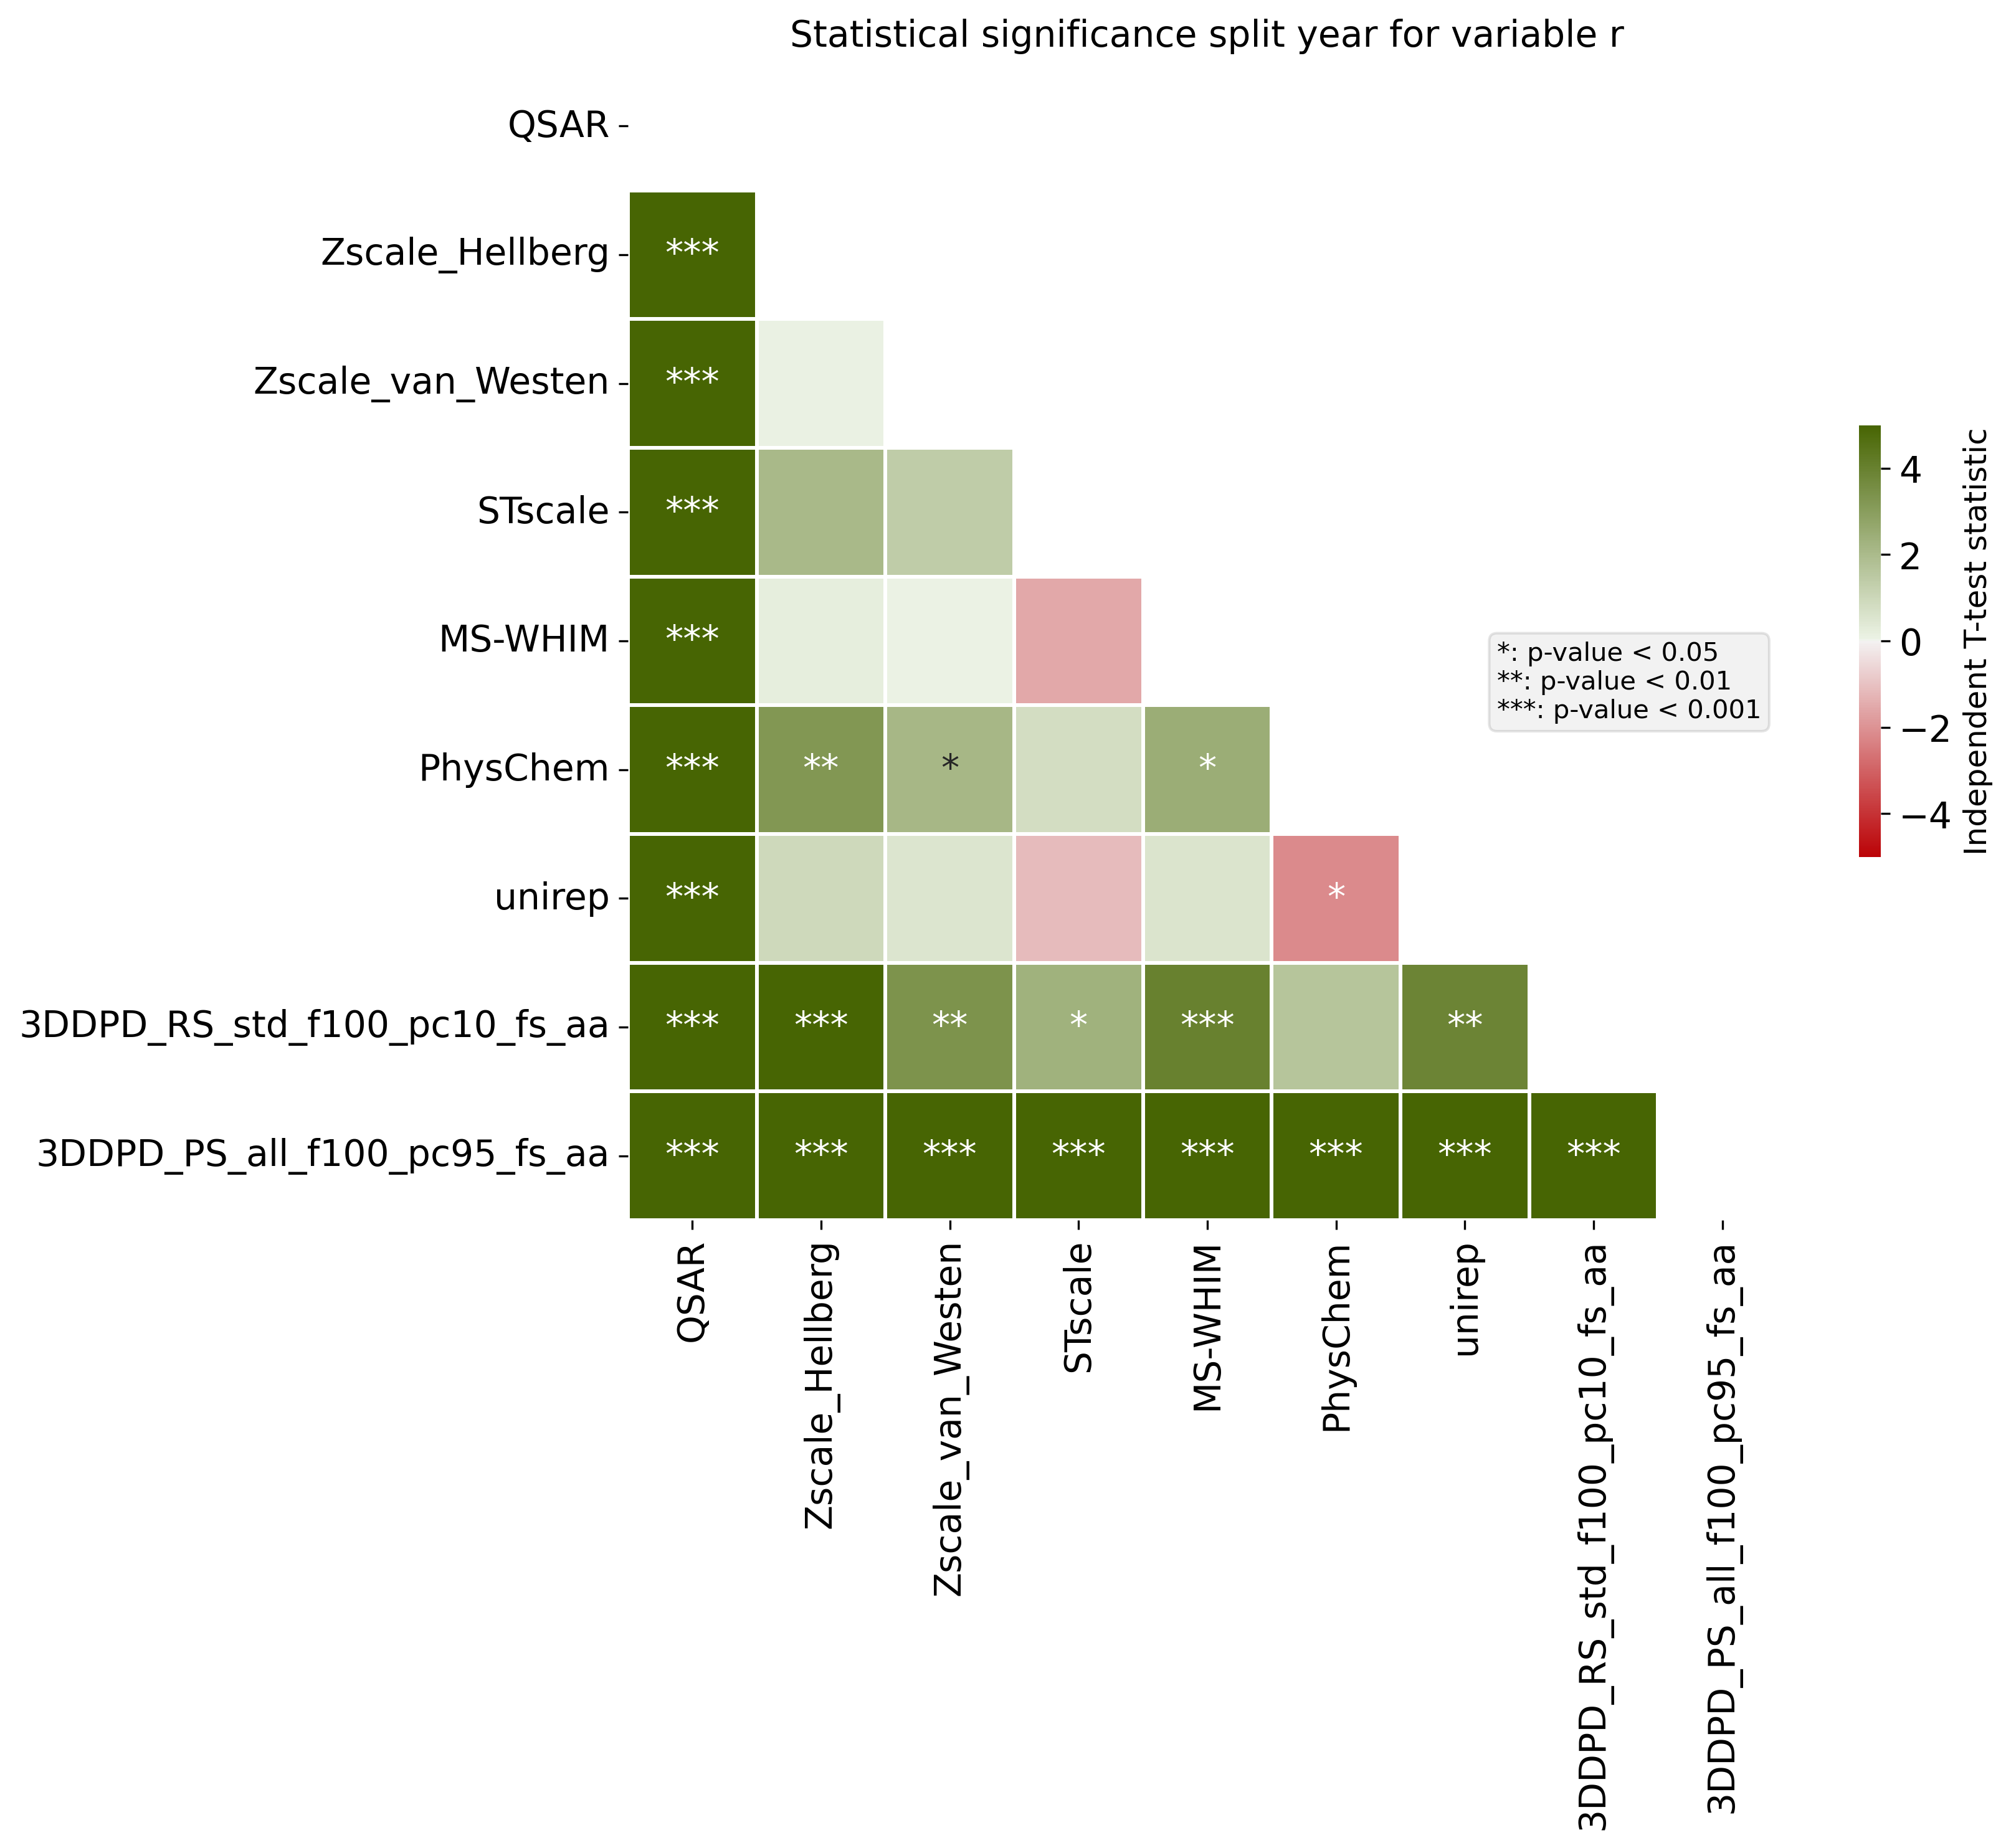

In [21]:
# Plot benchmark performance heatmaps for optimized 3DDPDs (pair-wise statistical significance as calculated with an
# independent T test ) - Random and temporal split; classification and regression

for split_type,metric in [('random','MCC'),('random','r'),('year','MCC'),('year','r')]:
    stat_significance_heatmap(get_results_to_plot(protein_descriptors_MS), split_type, metric,
                              protein_descriptors_MS, desc_set='benchmark',save=False)

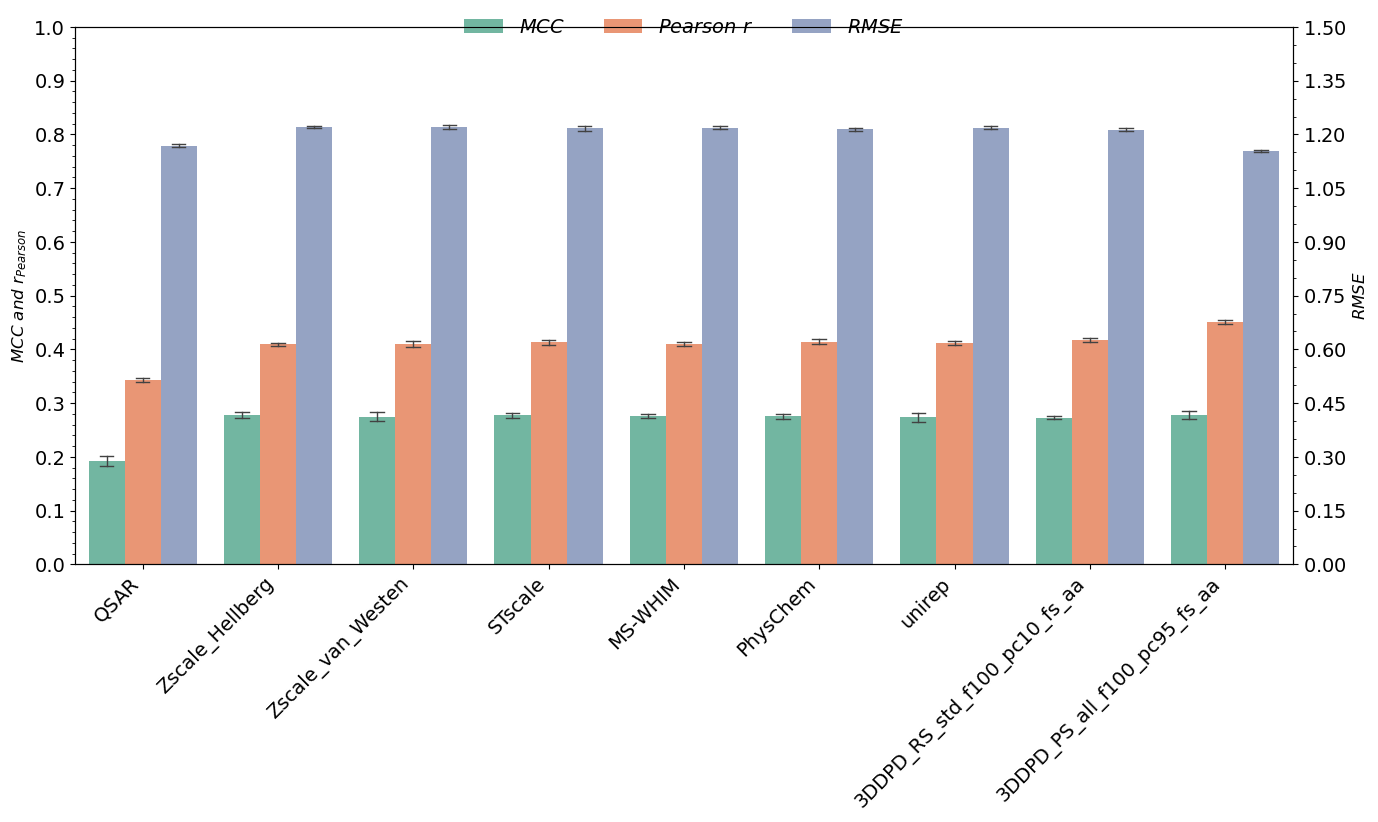

In [6]:
# Plot performance for all metrics aggregated (MCC, r, RMSE) - (barplots)
qsar_plot = plot_performance_aggregated(get_results_to_plot(protein_descriptors_MS), split='year', desc_filter=protein_descriptors_MS , desc_set='benchmark', zoom=False, save=False)

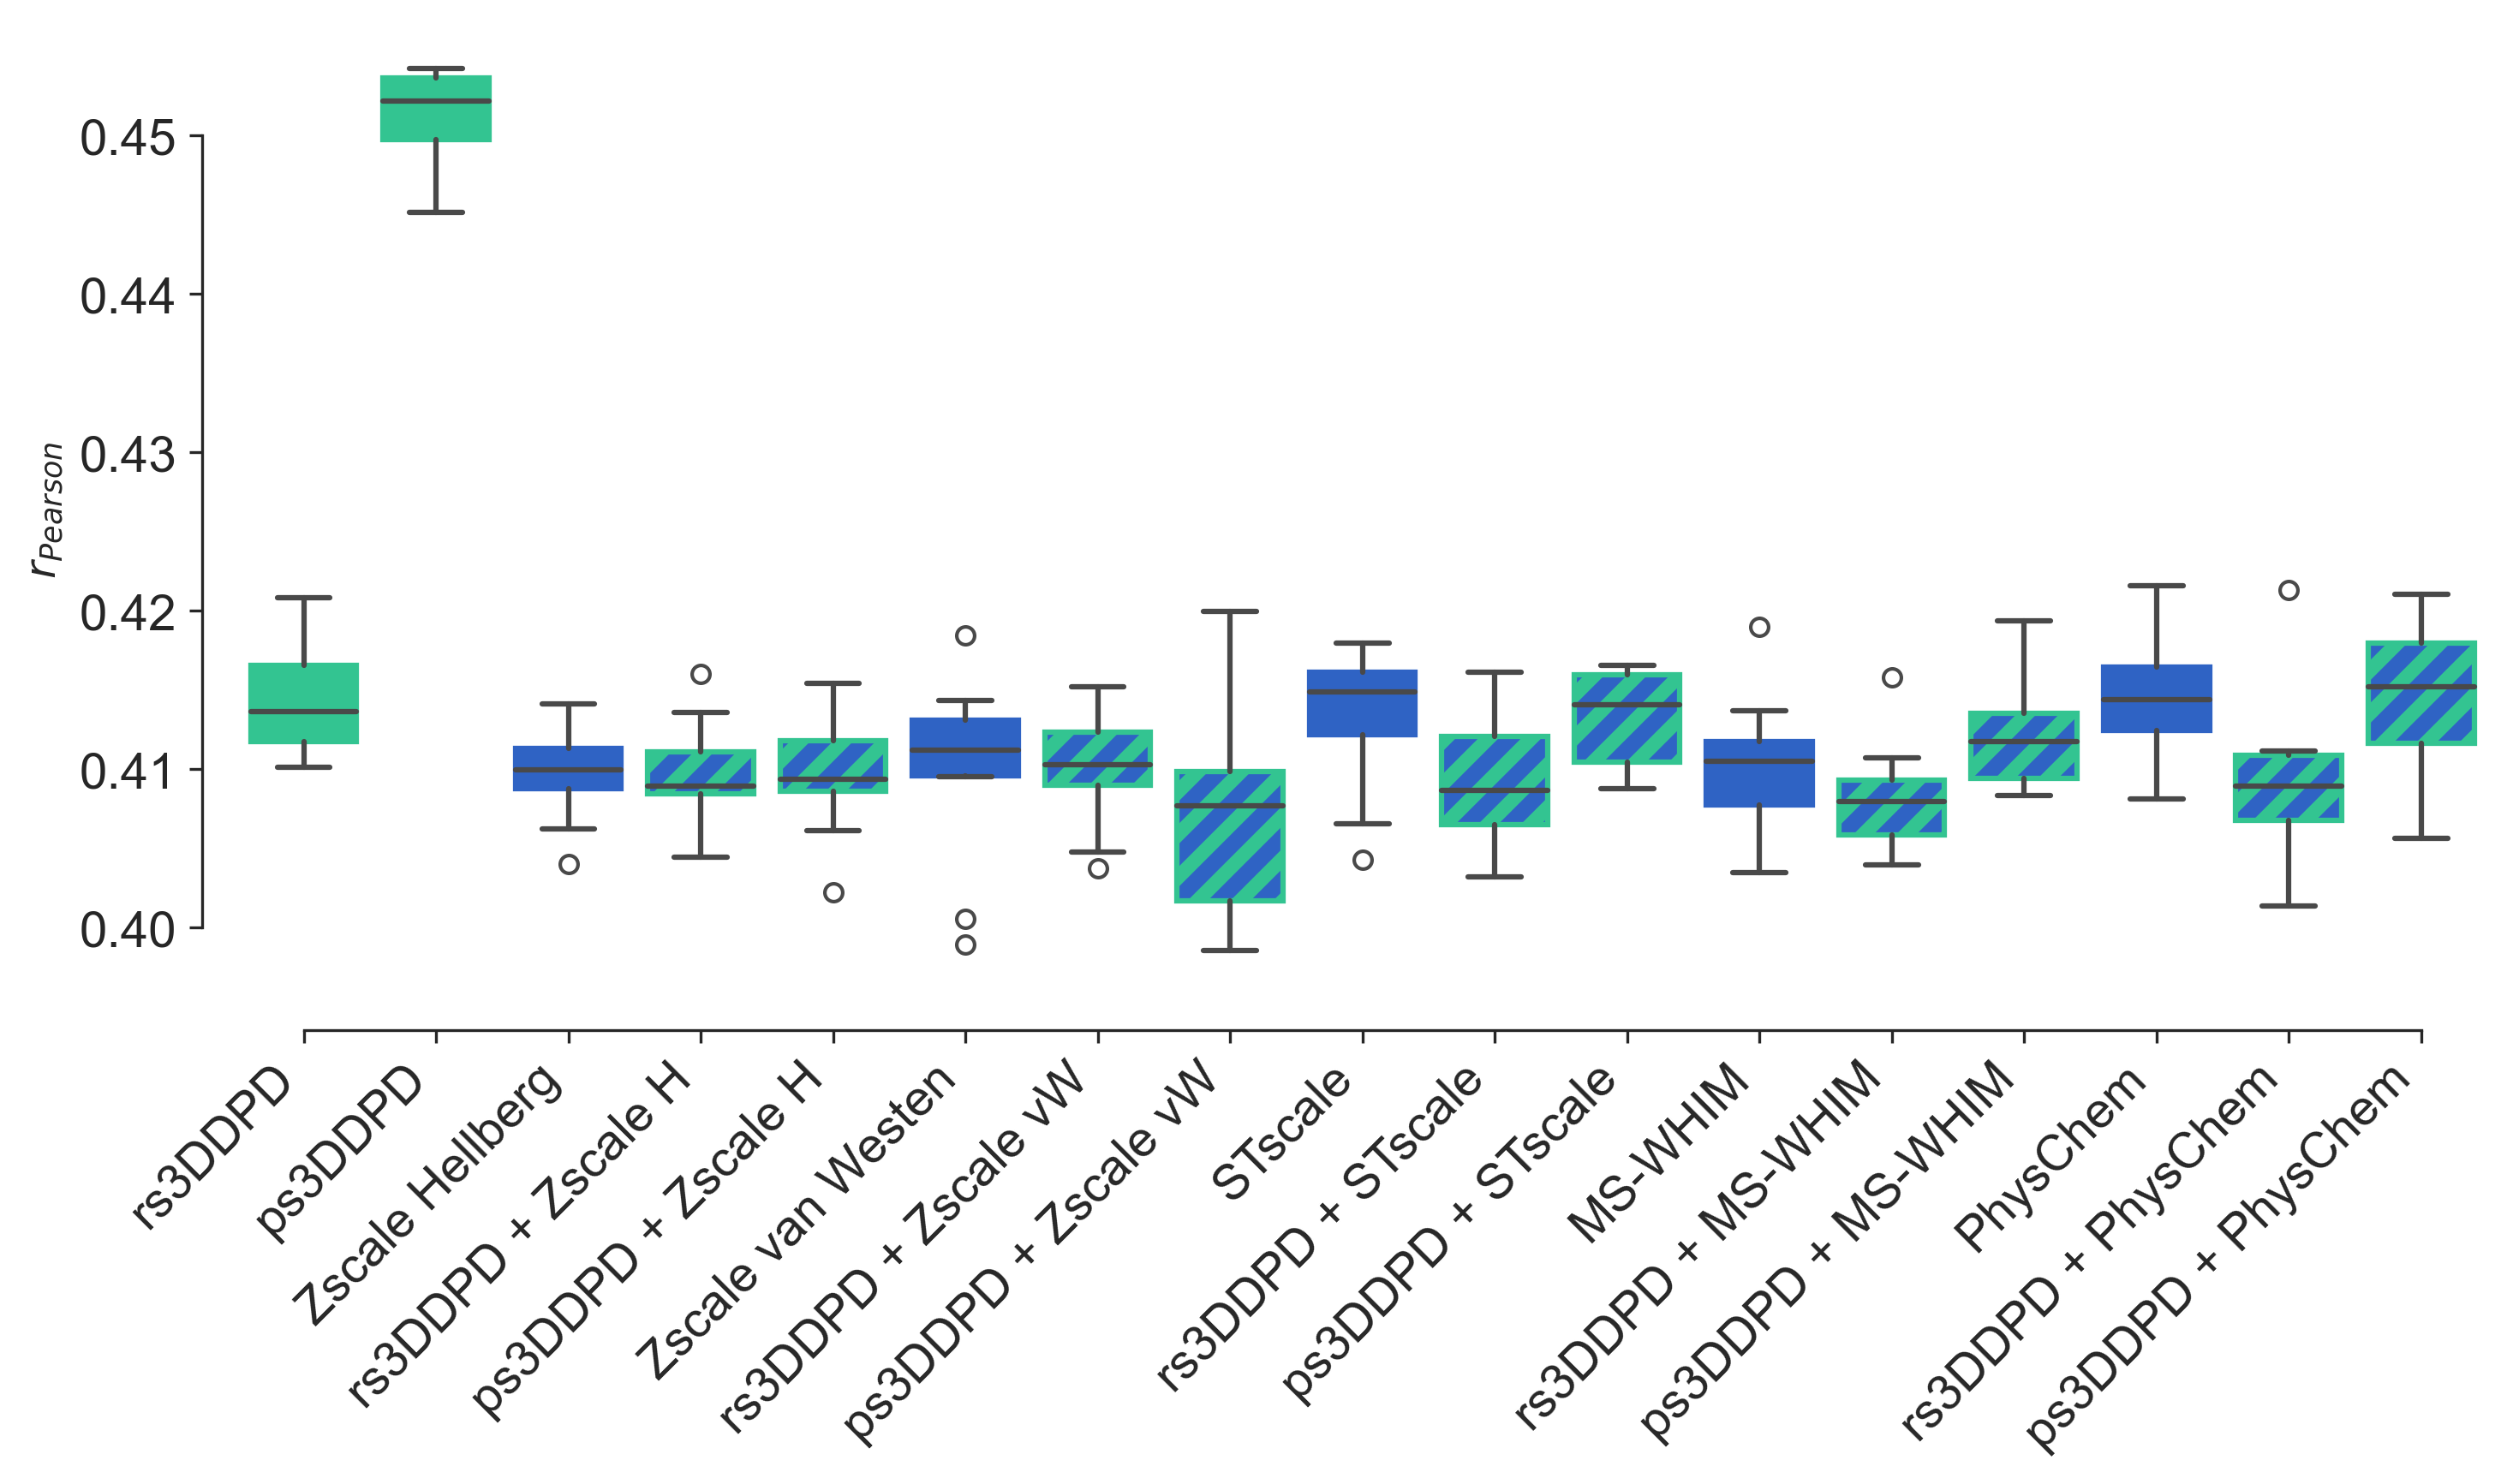

In [7]:
# Plot performance of descriptors in combination 
synergy_names = {'Zscale_Hellberg': 'Zscale Hellberg', 
              'Zscale_van_Westen': 'Zscale van Westen', 
              'STscale': 'STscale',
              'MS-WHIM': 'MS-WHIM', 
              'PhysChem': 'PhysChem',
              'unirep': 'Unirep',
              '3DDPD_RS_std_f100_pc5_fs_aa': 'rs3DDPD',
              '3DDPD_PS_all_f100_pc95_fs_aa': 'ps3DDPD',
              '3DDPD_RS_std_f100_pc5_fs_aa_Zscale_van_Westen': 'rs3DDPD + Zscale vW',
              '3DDPD_PS_all_f100_pc95_fs_aa_Zscale_van_Westen': 'ps3DDPD + Zscale vW',
              '3DDPD_RS_std_f100_pc5_fs_aa_Zscale_Hellberg': 'rs3DDPD + Zscale H',
              '3DDPD_PS_all_f100_pc95_fs_aa_Zscale_Hellberg': 'ps3DDPD + Zscale H',
              '3DDPD_RS_std_f100_pc5_fs_aa_STscale': 'rs3DDPD + STscale', 
              '3DDPD_PS_all_f100_pc95_fs_aa_STscale': 'ps3DDPD + STscale',
              '3DDPD_RS_std_f100_pc5_fs_aa_PhysChem': 'rs3DDPD + PhysChem', 
              '3DDPD_PS_all_f100_pc95_fs_aa_PhysChem': 'ps3DDPD + PhysChem',
               '3DDPD_RS_std_f100_pc5_fs_aa_MS-WHIM': 'rs3DDPD + MS-WHIM', 
              '3DDPD_PS_all_f100_pc95_fs_aa_MS-WHIM': 'ps3DDPD + MS-WHIM'

}

plot_performance(get_results_to_plot(protein_descriptors_synergy), split='year', desc_filter=protein_descriptors_synergy , desc_names=synergy_names,desc_set='synergy', variable = 'r', save=False, output_format='png',output_dir=os.path.join(pcm_dir,'analysis'))

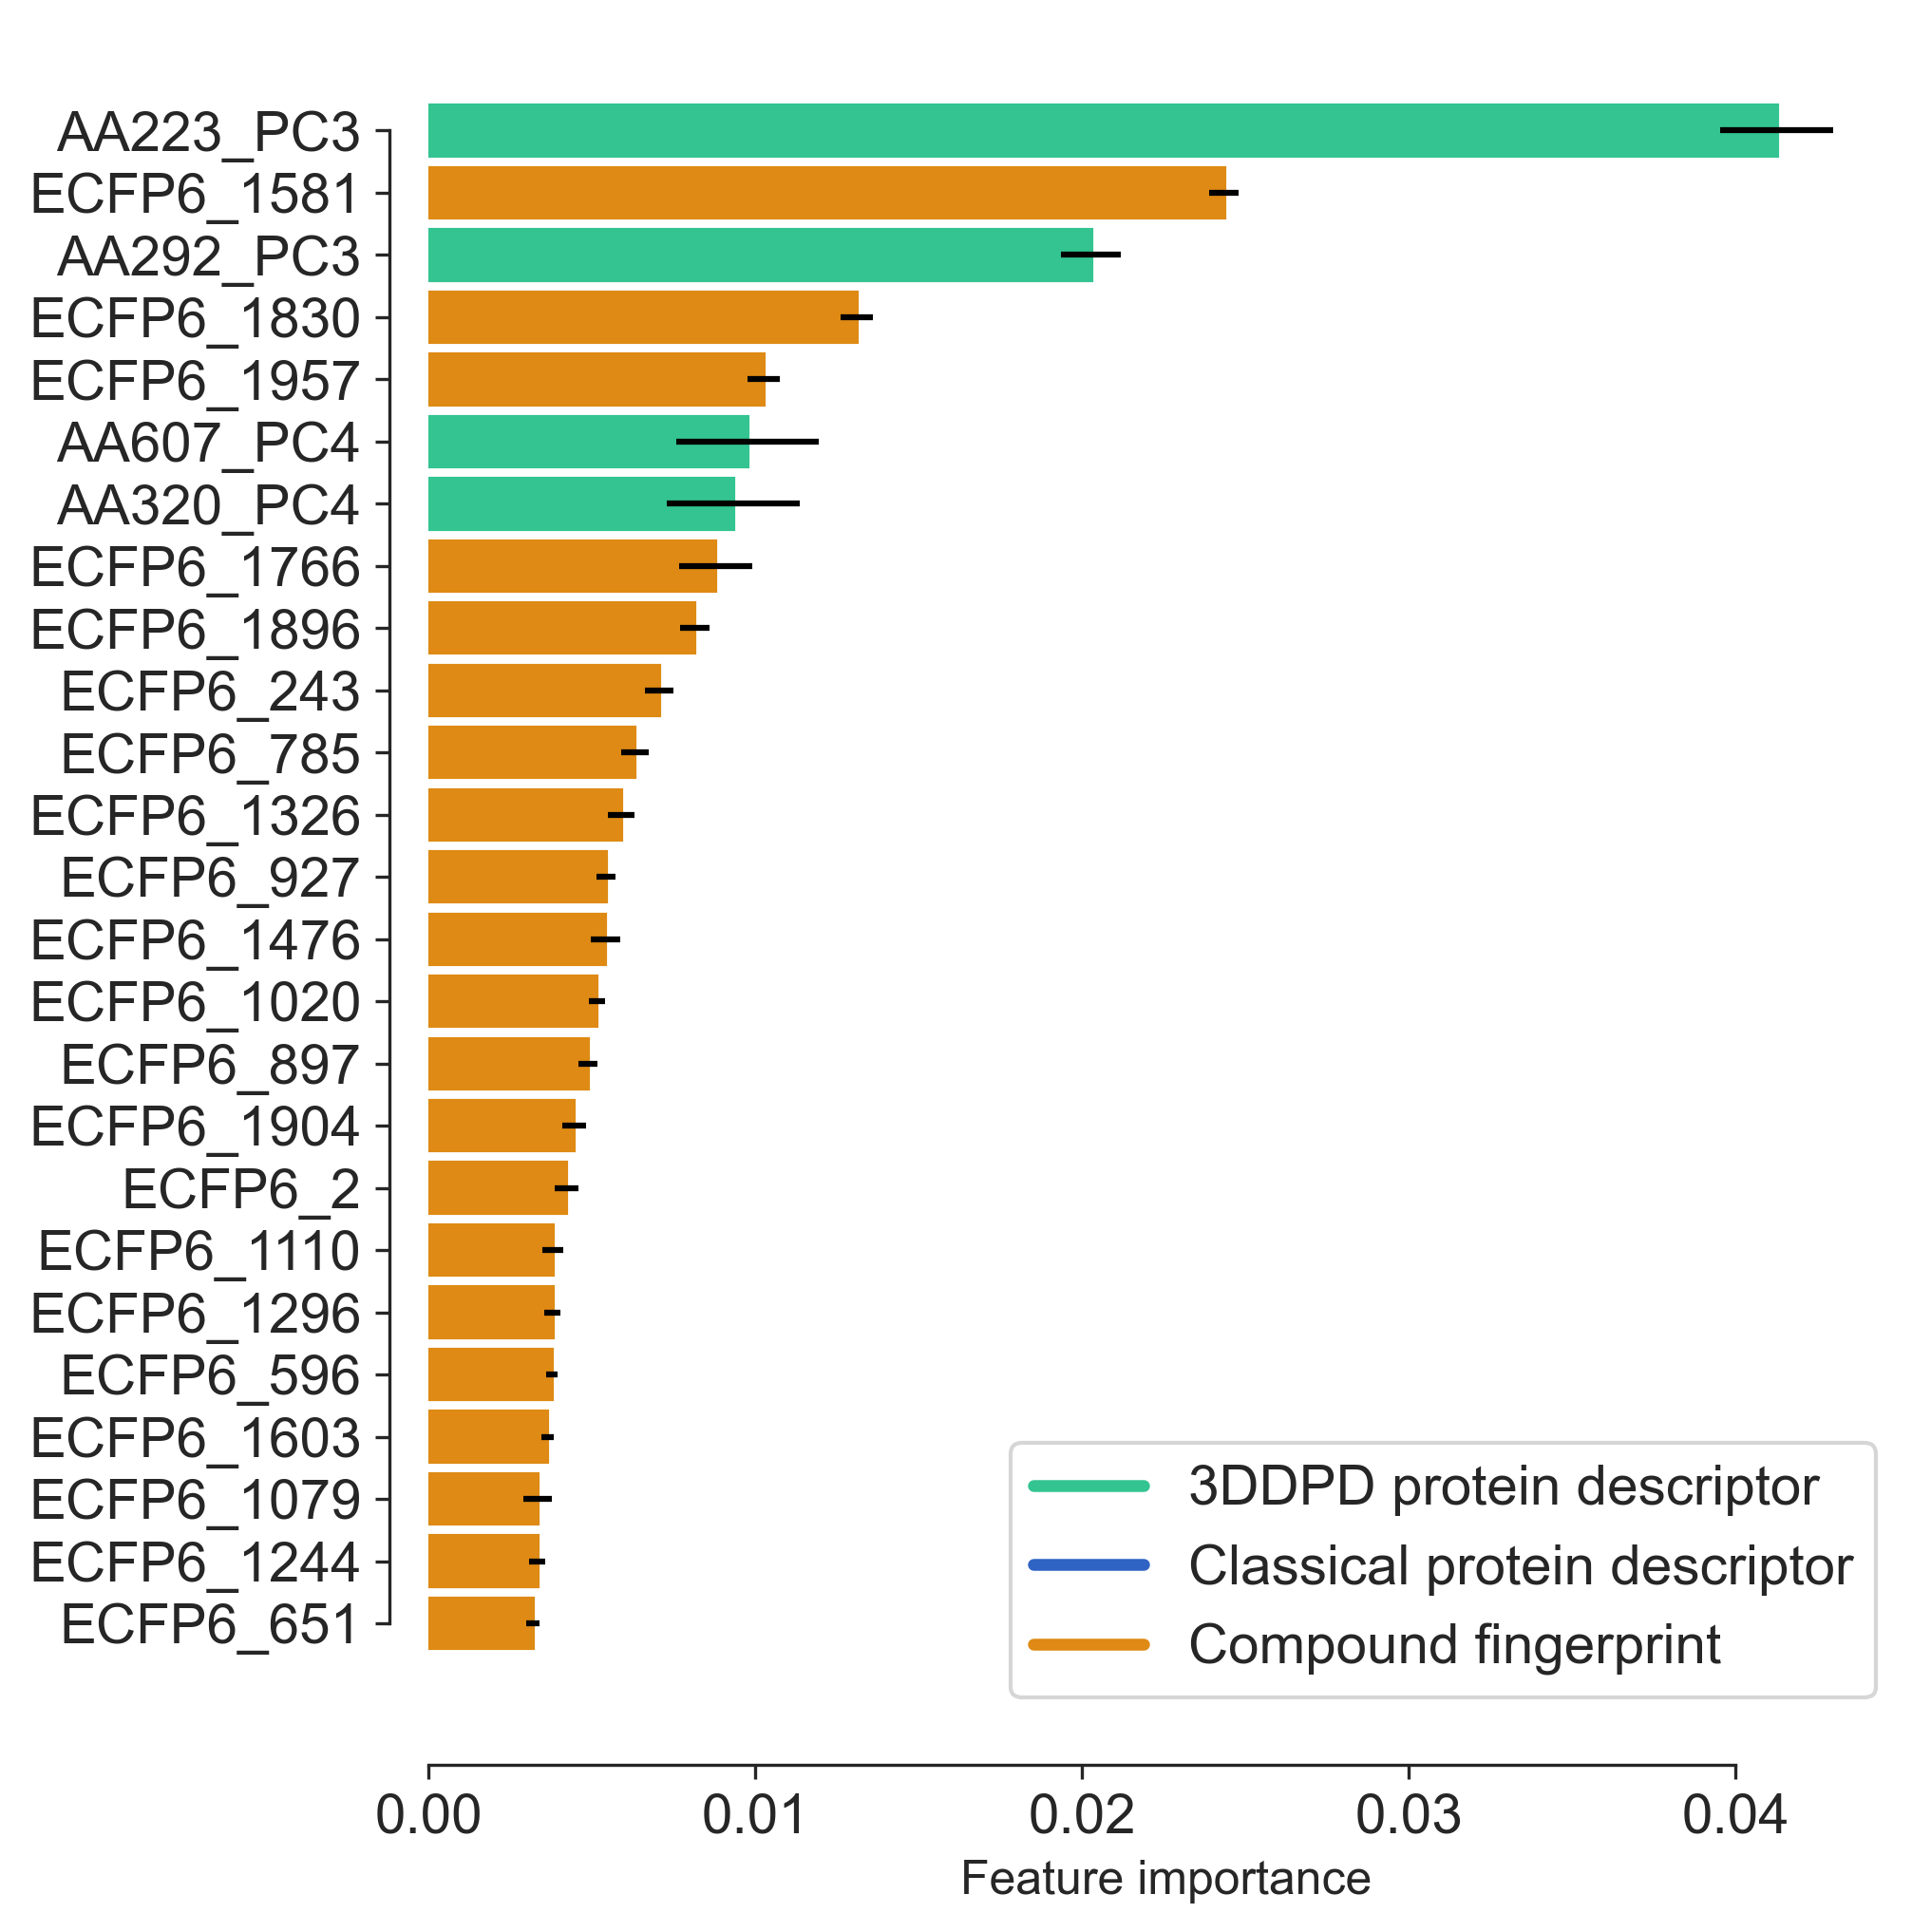

In [8]:
# Plot feature importance (best performing rs3DDPD)
plot_feature_importance(model_dir=os.path.join(pcm_dir, 'models', 'pcm'), model_type='regression',
                        protein_descriptor='3DDPD_RS_std_f100_pc5_fs_aa', split_by='Year', top=25, 
                        save=False,output_dir=os.path.join(pcm_dir,'analysis'))

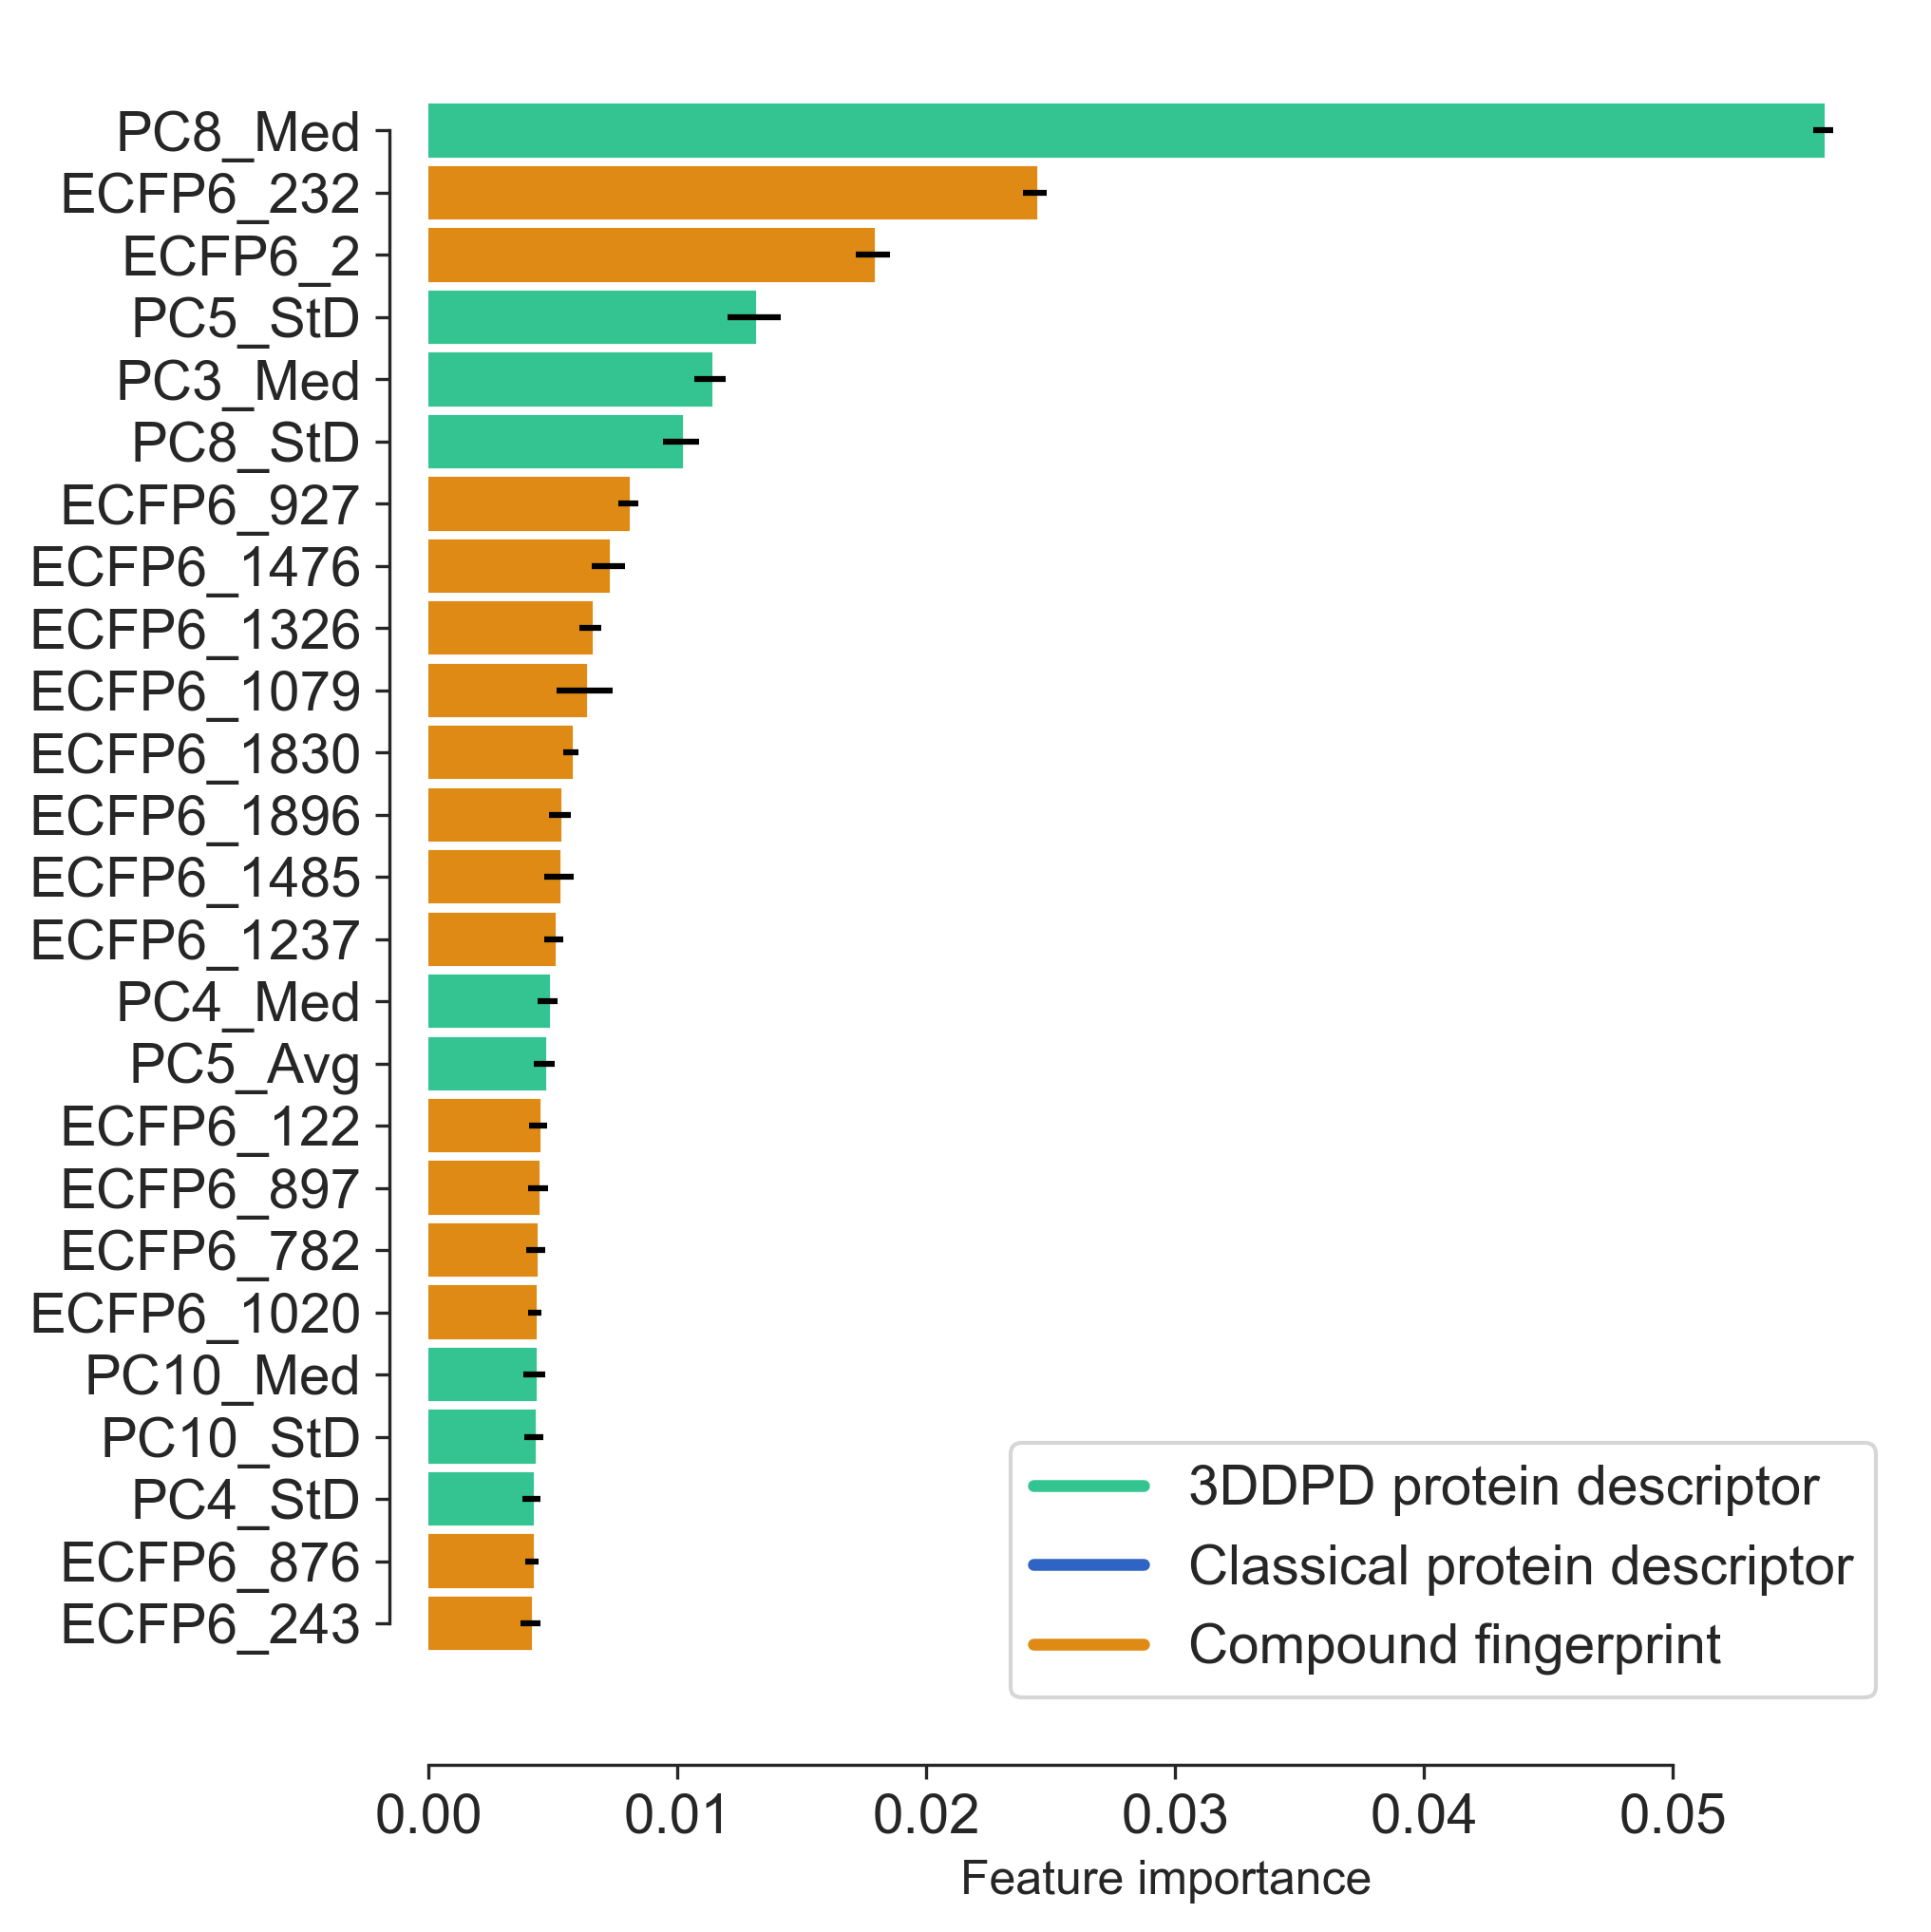

In [9]:
# Plot feature importance (best performing ps3DDPD)
plot_feature_importance(model_dir=os.path.join(pcm_dir, 'models', 'pcm'), model_type='regression',
                        protein_descriptor='3DDPD_PS_all_f100_pc95_fs_aa', split_by='Year', top=25, save=False,
                        output_dir=os.path.join(pcm_dir,'analysis'))

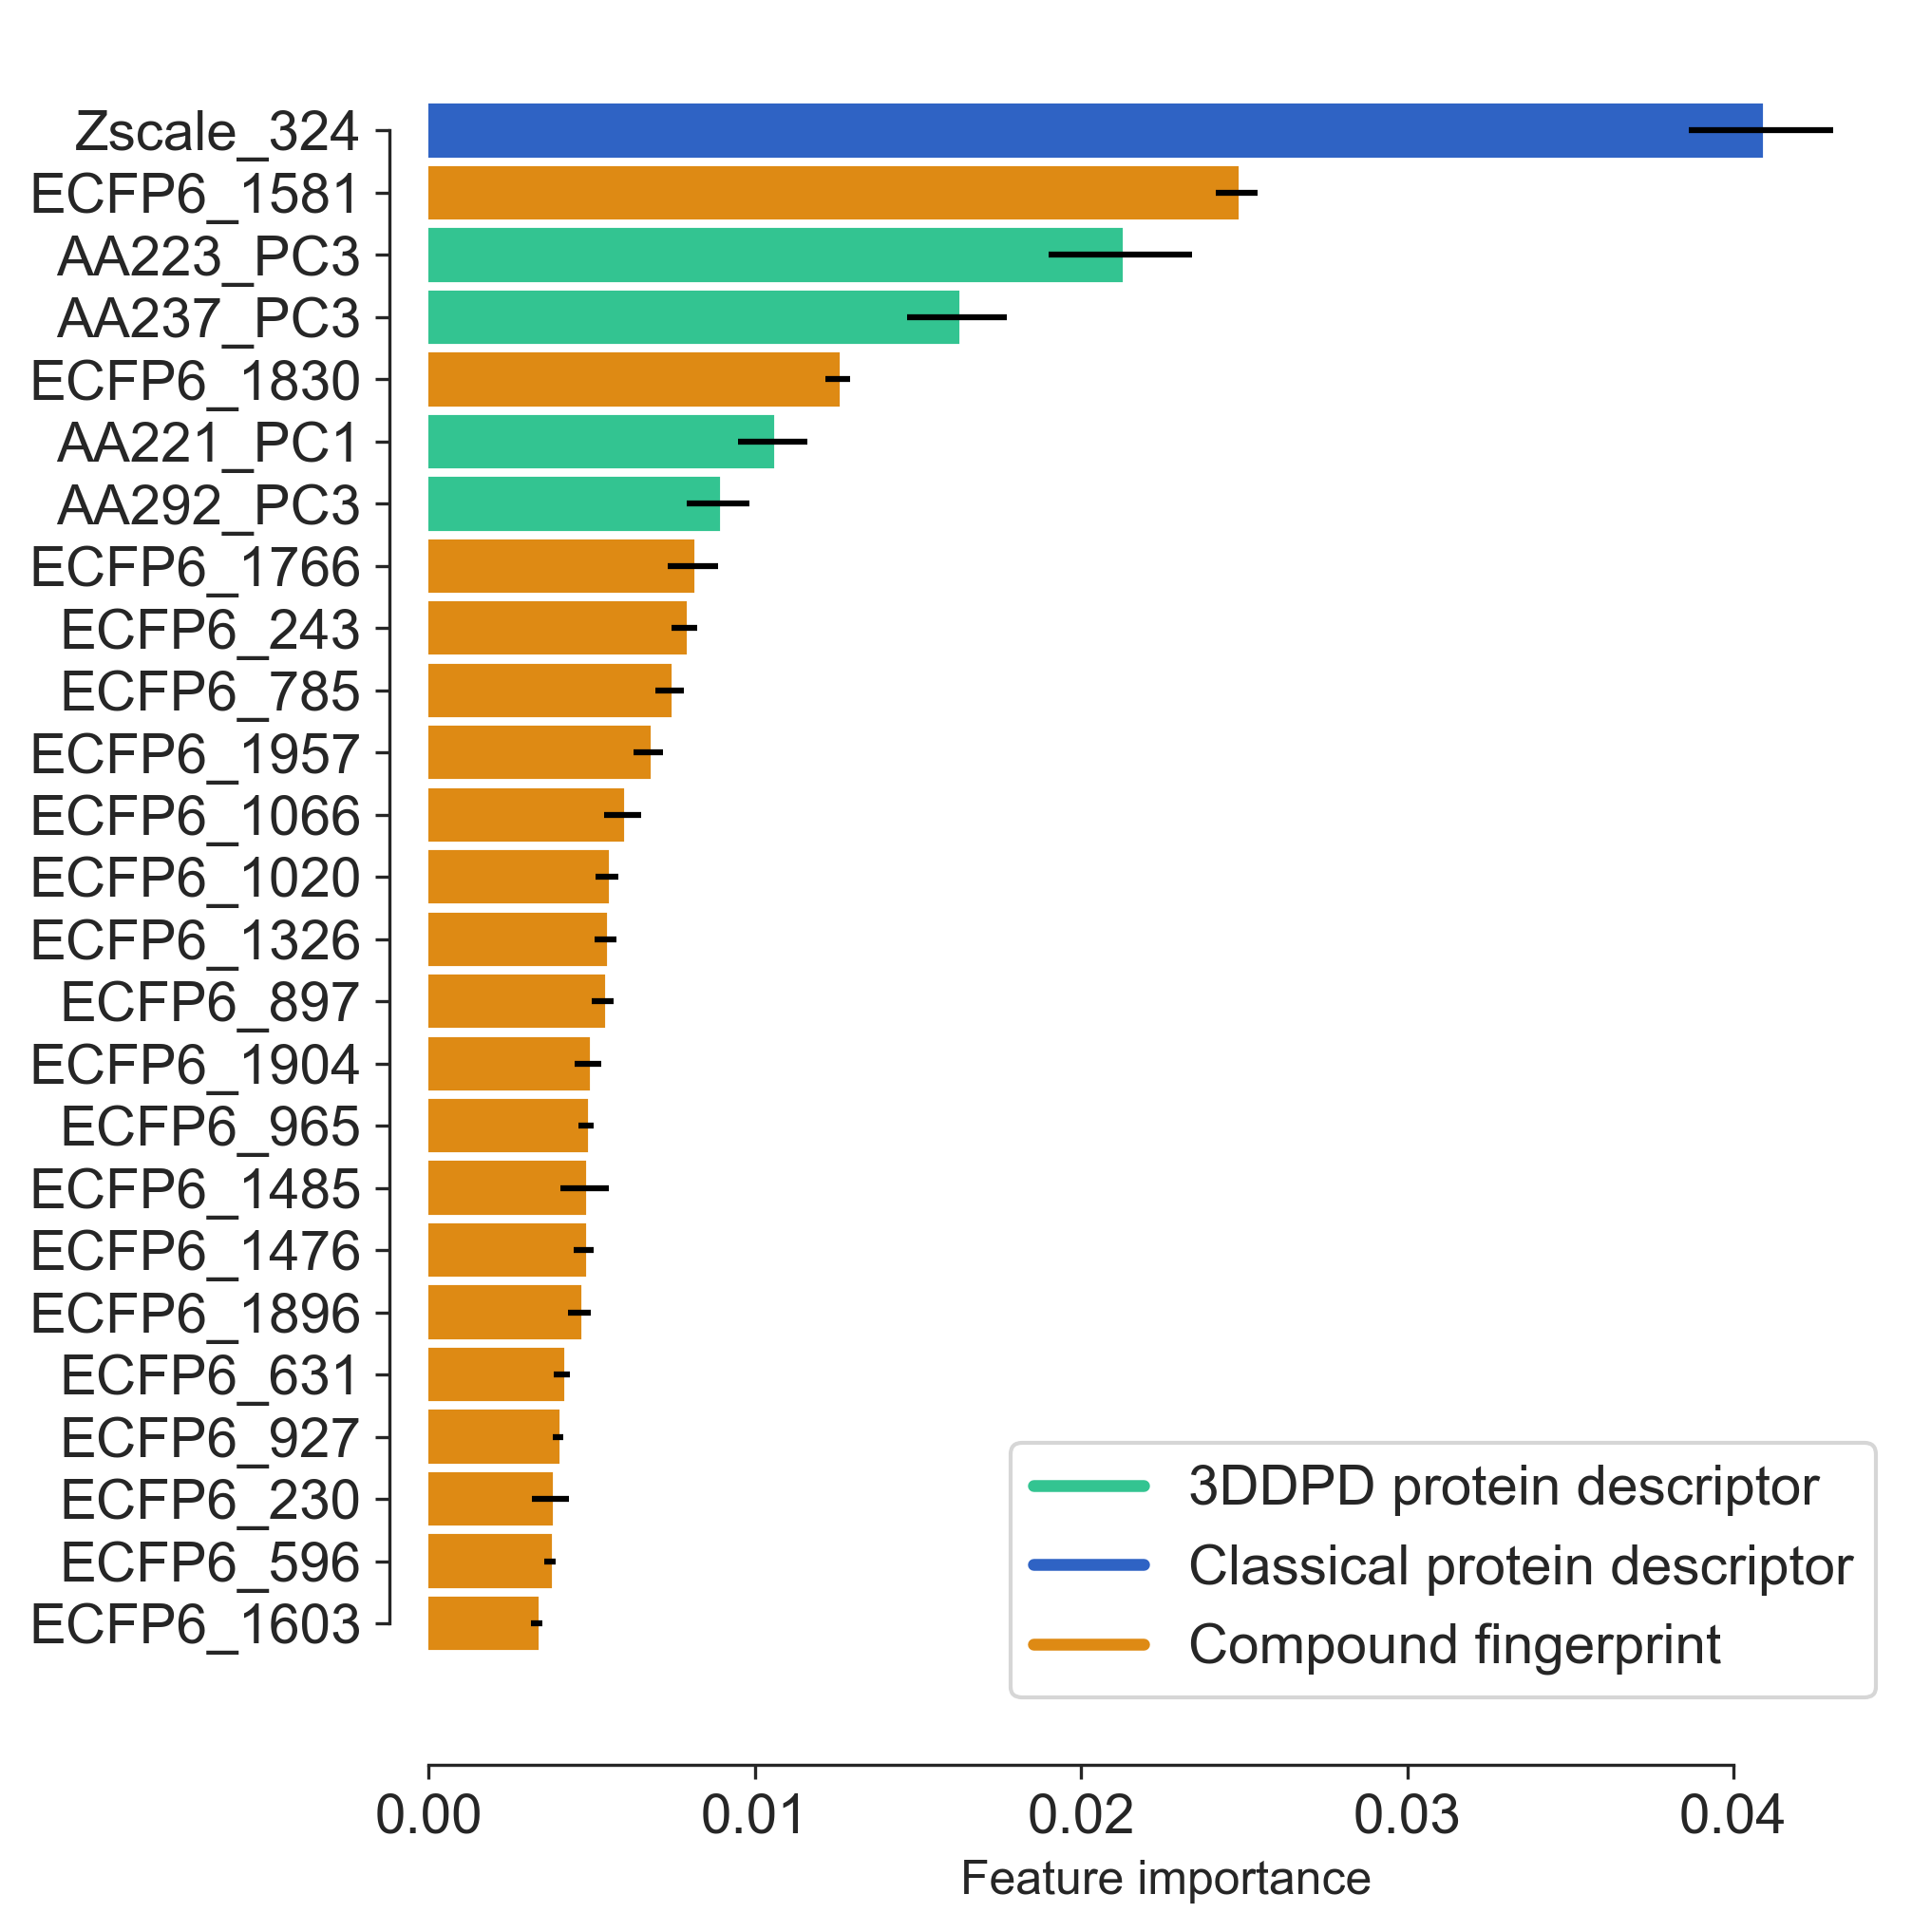

In [10]:
# Plot feature importance (synergystic effect)
plot_feature_importance(model_dir=os.path.join(pcm_dir, 'models', 'pcm'), model_type='regression',
                        protein_descriptor='3DDPD_RS_std_f100_pc5_fs_aa_Zscale_van_Westen', split_by='Year', top=25,
                        save=False,output_dir=os.path.join(pcm_dir,'analysis'))

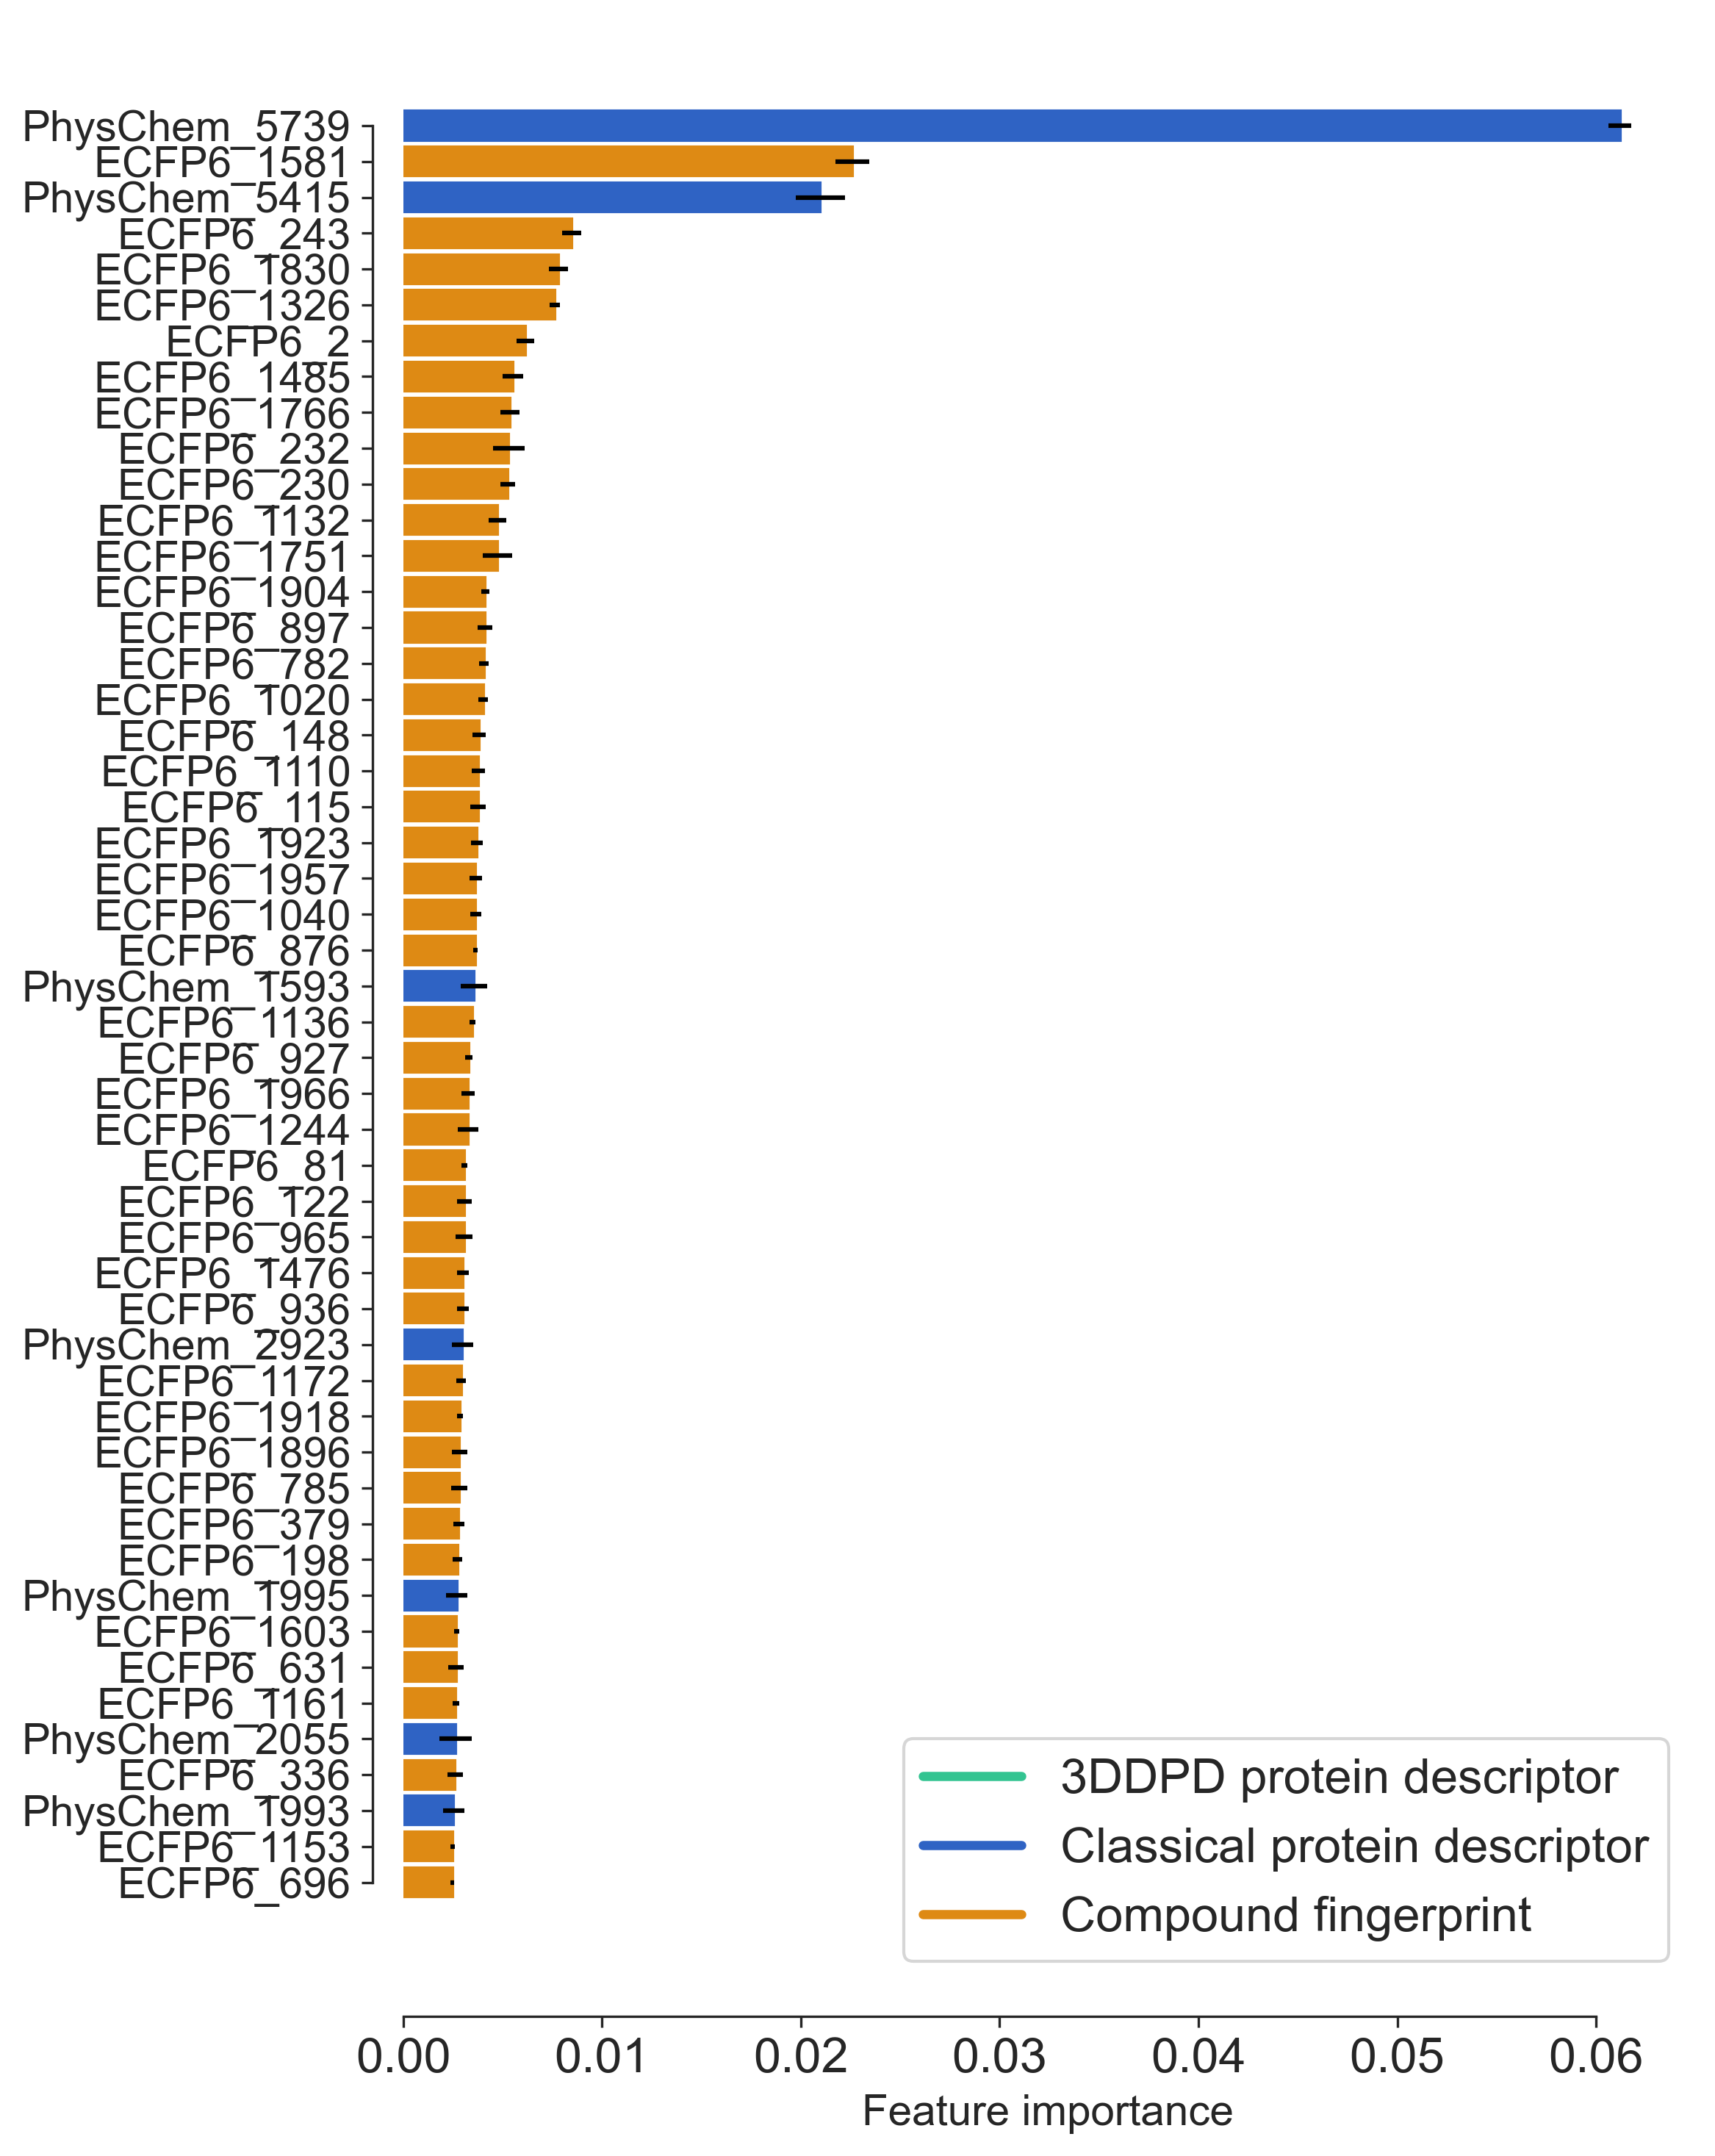

In [11]:
plot_feature_importance(model_dir=os.path.join(pcm_dir, 'models', 'pcm'), model_type='regression',
                        protein_descriptor='3DDPD_PS_all_f100_pc95_fs_aa_PhysChem', split_by='Year', top=50,
                        save=False,output_dir=os.path.join(pcm_dir,'analysis'))